# Imports

In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Machine learning
from sklearn.model_selection import GroupKFold
from sklearn.base import clone, BaseEstimator, TransformerMixin
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler

# Preprocessing
from sklearn.preprocessing import PowerTransformer, MinMaxScaler, RobustScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import set_config

# Optimization
import optuna
from functools import partial

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# File and data handling
import ast
import csv
import pickle
import joblib

# Language processing
# from lang2vec.lang2vec import get_features
# import lang2vec as l2v

# Network analysis
import networkx as nx

# Time handling
from datetime import timedelta

# Data structures
from collections import defaultdict

# Data Exploration

## General statistics

We calculated the basic statistics for each language such as mininmum / maximum / mean, etc. number of nodes over sentences in the correspoinding language.

In [ ]:
language_stats = defaultdict(list)
all_counts = []
for _, row in train_data.iterrows():
    language = row['language']
    node_count = row['n']
    
    # Store statistics
    language_stats[language].append(node_count)
    all_counts.append(node_count)

stats = []
for lang, counts in language_stats.items():
    stats.append({
        'language': lang,
        'min': np.min(counts),
        'max': np.max(counts),
        'mean': np.mean(counts),
        'median': np.median(counts),
        'std': np.std(counts),
        'total_sentences': len(counts)
    })

lang_stats_df = pd.DataFrame(stats)

# Global statistics
global_stats = {
    'min': np.min(all_counts),
    'max': np.max(all_counts),
    'mean': np.mean(all_counts),
    'median': np.median(all_counts),
    'std': np.std(all_counts),
    'total_sentences': len(all_counts)
}

print("Per-language statistics:")
print(lang_stats_df)
print("\nGlobal statistics:")
print(global_stats)

Per-language statistics:
      language  min  max    mean  median       std  total_sentences
0     Japanese    6   70  25.812    25.0  9.697456              500
1      Finnish    3   33  13.572    13.0  5.464871              500
2     Galician    3   55  21.234    20.0  8.774238              500
3      English    4   48  18.830    18.0  7.223649              500
4        Hindi    4   52  21.826    21.0  8.603239              500
5       French    4   54  22.380    21.0  8.906829              500
6      Italian    3   59  21.680    20.5  9.030703              500
7   Indonesian    3   44  17.150    17.0  6.830190              500
8      Swedish    4   49  17.252    17.0  6.921885              500
9      Spanish    3   58  21.194    20.0  8.566000              500
10   Icelandic    4   52  16.754    16.0  6.932928              500
11      German    4   47  18.764    18.0  7.384870              500
12      Korean    3   42  15.146    15.0  5.996723              500
13      Polish    3   3

## Checking normality of features

We checked the normality of main centrality features per each sentence and computed the number and fraction of features that were normal in each language according to Shapiro-Wilk test. For example, we can see that betweenness feature follows normal distribution only for 14% of sentences in Arabic language.

In [ ]:
import pandas as pd
from scipy.stats import shapiro, skew, kurtosis

def compute_normality_stats(features_df, feature_names, min_nodes=3):
    """
    Computes normality statistics for each feature within each sentence.
    Returns a DataFrame with sentence_id, feature, p_value, skewness, kurtosis, normal.
    """
    results = []
    for (sentence, language), group in features_df.groupby(['sentence', 'language']):
        for feature in feature_names:
            values = group[feature].values
            if len(values) >= min_nodes:
                # Shapiro-Wilk test
                stat, p_value = shapiro(values)
                # Skewness and kurtosis
                skewness = skew(values)
                kurt = kurtosis(values)
                # Normal if p > 0.05
                is_normal = (p_value > 0.05) 
                results.append({
                    'language': language,
                    'sentence': sentence,
                    'feature': feature,
                    'p_value': p_value,
                    'skewness': skewness,
                    'kurtosis': kurt,
                    'normal': is_normal
                })
    return pd.DataFrame(results)


In [ ]:
def aggregate_normality(normality_df):
    """
    Aggregates normality results across all sentences for each feature.
    Returns a summary DataFrame.
    """
    summary = (
        normality_df
        .groupby(['feature', 'language'])['normal']
        .agg(['count', 'sum', 'mean'])
        .rename(columns={'count': 'num_sentences', 'sum': 'num_normal', 'mean': 'fraction_normal'})
        .reset_index()
    )
    return summary

In [ ]:
feature_names = ['degree', 'closeness', 'betweenness', 'pagerank', 'load', 'eigencentrality']

normality_df = compute_normality_stats(expanded_dataset, feature_names)
summary = aggregate_normality(normality_df)
print(summary)


             feature    language  num_sentences  num_normal  fraction_normal
0        betweenness      Arabic            500          73            0.146
1        betweenness     Chinese            500          50            0.100
2        betweenness       Czech            500          82            0.164
3        betweenness     English            500          37            0.074
4        betweenness     Finnish            500          79            0.158
5        betweenness      French            500          18            0.036
6        betweenness    Galician            500          24            0.048
7        betweenness      German            500          35            0.070
8        betweenness       Hindi            500          41            0.082
9        betweenness   Icelandic            500          72            0.144
10       betweenness  Indonesian            500          58            0.116
11       betweenness     Italian            500          34            0.068

We also checked the normality over the whole dataset of class-conditionals to confirm that the Bayesian models would not be appropriate in our case

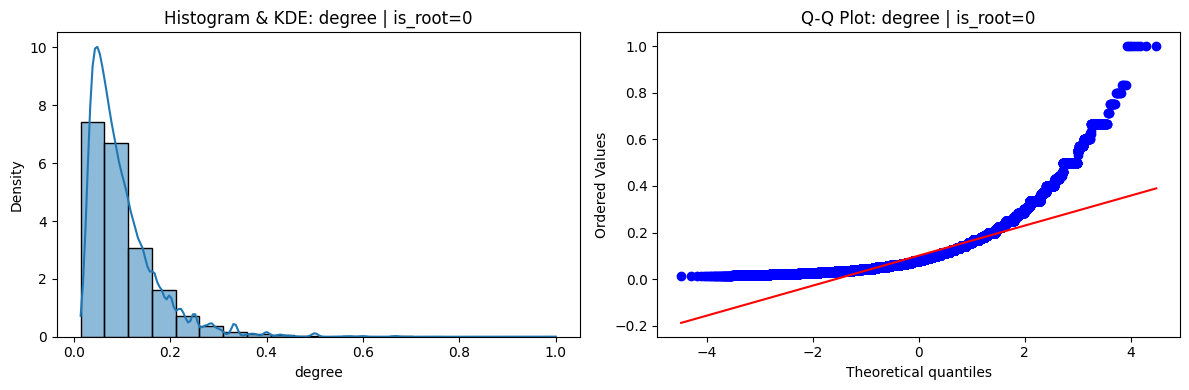

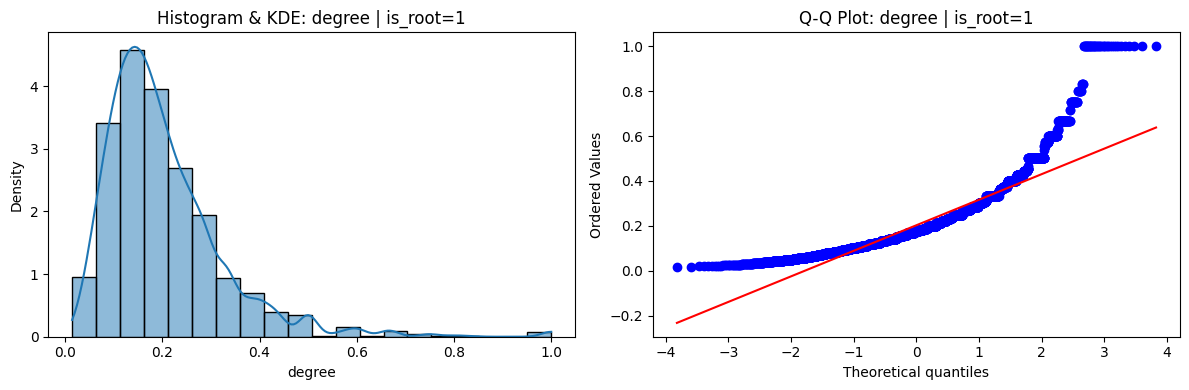

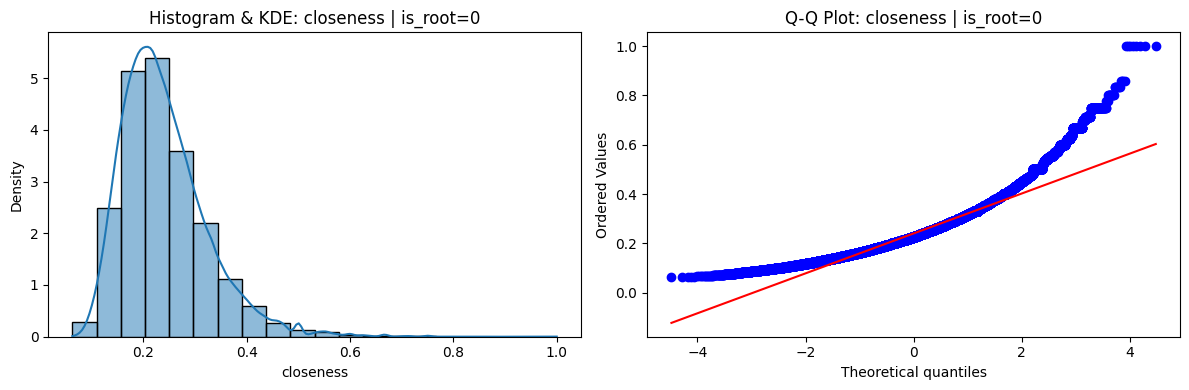

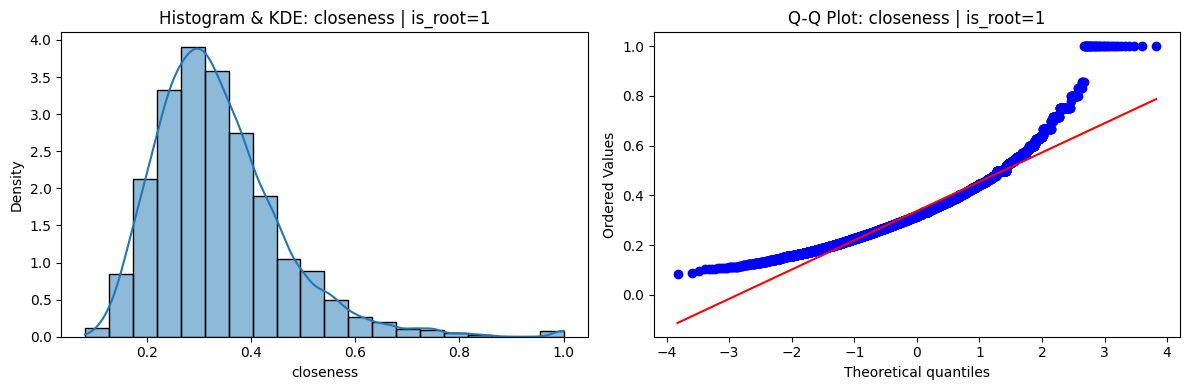

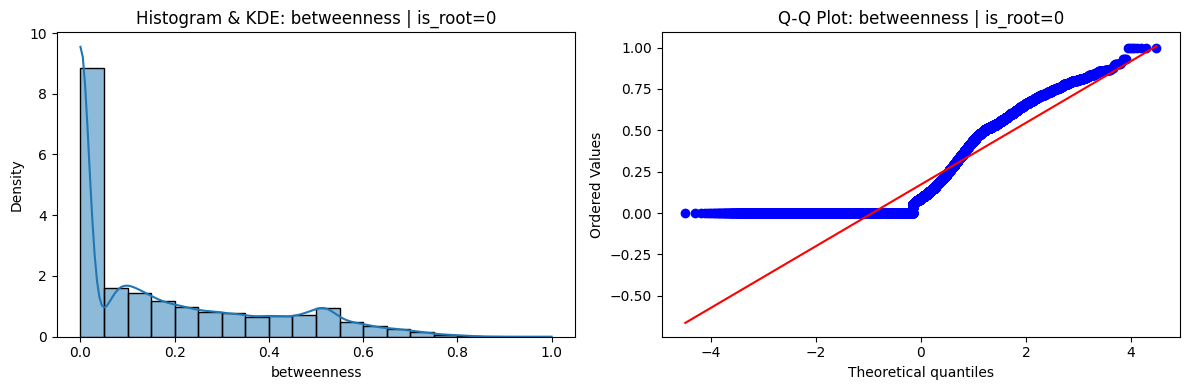

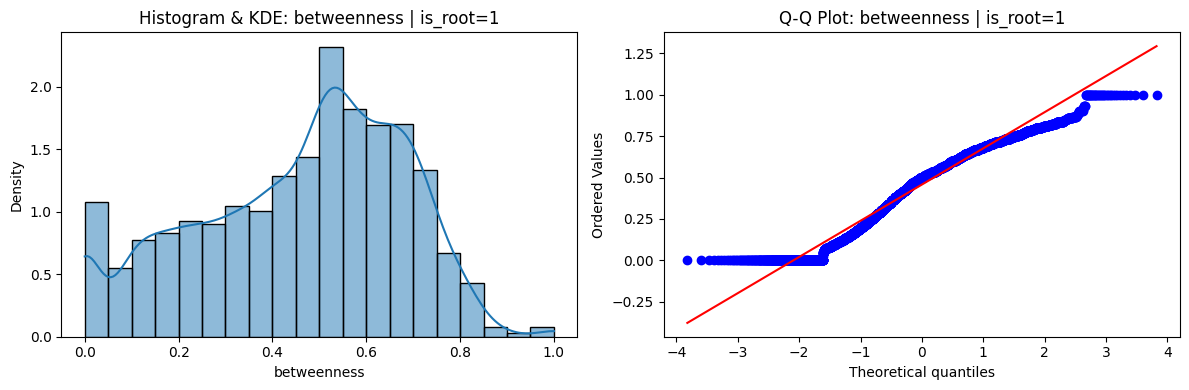

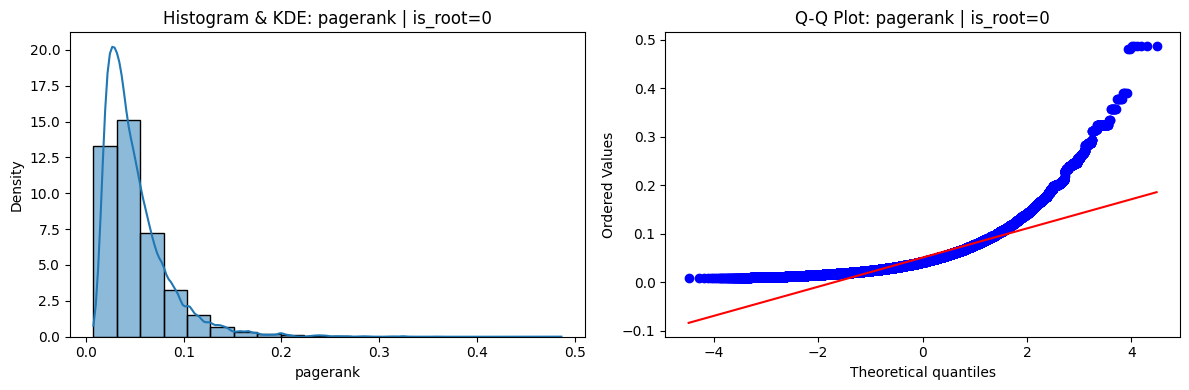

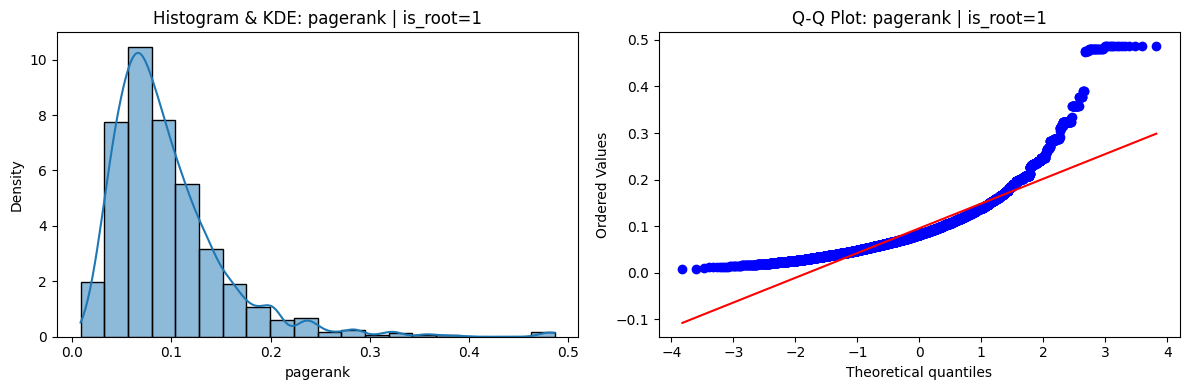

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Feature list
features = ['degree', 'closeness', 'betweenness', 'pagerank']
class_col = 'is_root'

for feat in features:
    for cls in sorted(expanded_dataset[class_col].unique()):
        data = expanded_dataset[expanded_dataset[class_col] == cls][feat].dropna()
        label = f"{feat} | is_root={cls}"
        
        # Histogram and KDE
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        sns.histplot(data, kde=True, stat="density", bins=20)
        plt.title(f"Histogram & KDE: {label}")
        plt.xlabel(feat)
        plt.ylabel('Density')
        
        # Q-Q plot
        plt.subplot(1, 2, 2)
        stats.probplot(data, dist="norm", plot=plt)
        plt.title(f"Q-Q Plot: {label}")
        
        plt.tight_layout()
        plt.show()
        


## Checking outliers in features

We also checked the outliers count and average outlier number per sentence in each feature for each language using IQR

In [ ]:
def detect_outliers_iqr(feature_values):
    """Detect outliers using IQR for a single feature."""
    Q1 = np.percentile(feature_values, 25)
    Q3 = np.percentile(feature_values, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (feature_values < lower_bound) | (feature_values > upper_bound)

In [ ]:
from scipy.stats import shapiro

feature_names = ['degree', 'harmonic', 'betweenness', 'pagerank']
outlier_stats = {feature: [] for feature in feature_names}
language_stats = defaultdict(lambda: {feature: [] for feature in feature_names})
normality_results = []
for _, row in train_data.iterrows():
    language = row['language']
    sentence_id = row['sentence']
    n = row['n']  
    edgelist = parse_edgelist(row['edgelist'])
    root = int(row['root'])
    
    # Compute centrality metrics using the provided function
    cent_dict = centralities(edgelist)
    
    feature_arrays = {
        'degree': [],
        'harmonic': [],
        'betweenness': [],
        'pagerank': []
    }
    for v, (dc, cc, bc, pc) in cent_dict.items():
        feature_arrays['degree'].append(dc)
        feature_arrays['harmonic'].append(cc)
        feature_arrays['betweenness'].append(bc)
        feature_arrays['pagerank'].append(pc)
        
    for feature, values in cent_dict.items():
        stat, p = shapiro(values)
        normality_results.append({
            'language': language,
            'sentence_id': sentence_id,
            'feature': feature,
            'p_value': p,
            'is_normal': p > 0.05  # Alpha=0.05
        })
    
    # Step 3: Detect outliers per feature in this sentence
    for feature in feature_names:
        is_outlier = detect_outliers_iqr(feature_arrays[feature])
        outlier_stats[feature].append(np.sum(is_outlier))
        language_stats[language][feature].append(np.sum(is_outlier))
        

# Convert to DataFrame
normality_df = pd.DataFrame(normality_results)
outlier_df = pd.DataFrame({
    'feature': feature_names,
    'total_outliers': [np.sum(counts) for counts in outlier_stats.values()],
    'avg_outliers_per_sentence': [np.mean(counts) for counts in outlier_stats.values()]
})

In [ ]:
pd.set_option('display.max_rows', None)

In [ ]:
results = []
for lang in language_stats:
    for feature in feature_names:
        counts = language_stats[lang][feature]
        if counts:  # Only if there are valid sentences
            results.append({
                'language': lang,
                'feature': feature,
                'total_outliers': np.sum(counts),
                'avg_outliers_per_sentence': np.mean(counts),
                'max_outliers_in_sentence': np.max(counts),
                'min_outliers_in_sentence': np.min(counts)
            })

# Convert to DataFrame
outlier_df = pd.DataFrame(results)
print(outlier_df)

      language      feature  total_outliers  avg_outliers_per_sentence  \
0     Japanese       degree            1419                      2.838   
1     Japanese     harmonic              70                      0.140   
2     Japanese  betweenness             256                      0.512   
3     Japanese     pagerank            1069                      2.138   
4      Finnish       degree             385                      0.770   
5      Finnish     harmonic             140                      0.280   
6      Finnish  betweenness             255                      0.510   
7      Finnish     pagerank             329                      0.658   
8     Galician       degree             604                      1.208   
9     Galician     harmonic             106                      0.212   
10    Galician  betweenness             327                      0.654   
11    Galician     pagerank             426                      0.852   
12     English       degree           

## Scaling Effect

Below we compare the distributions and ROC-AUC score of eccentricity before and after applying MinMaxScaler

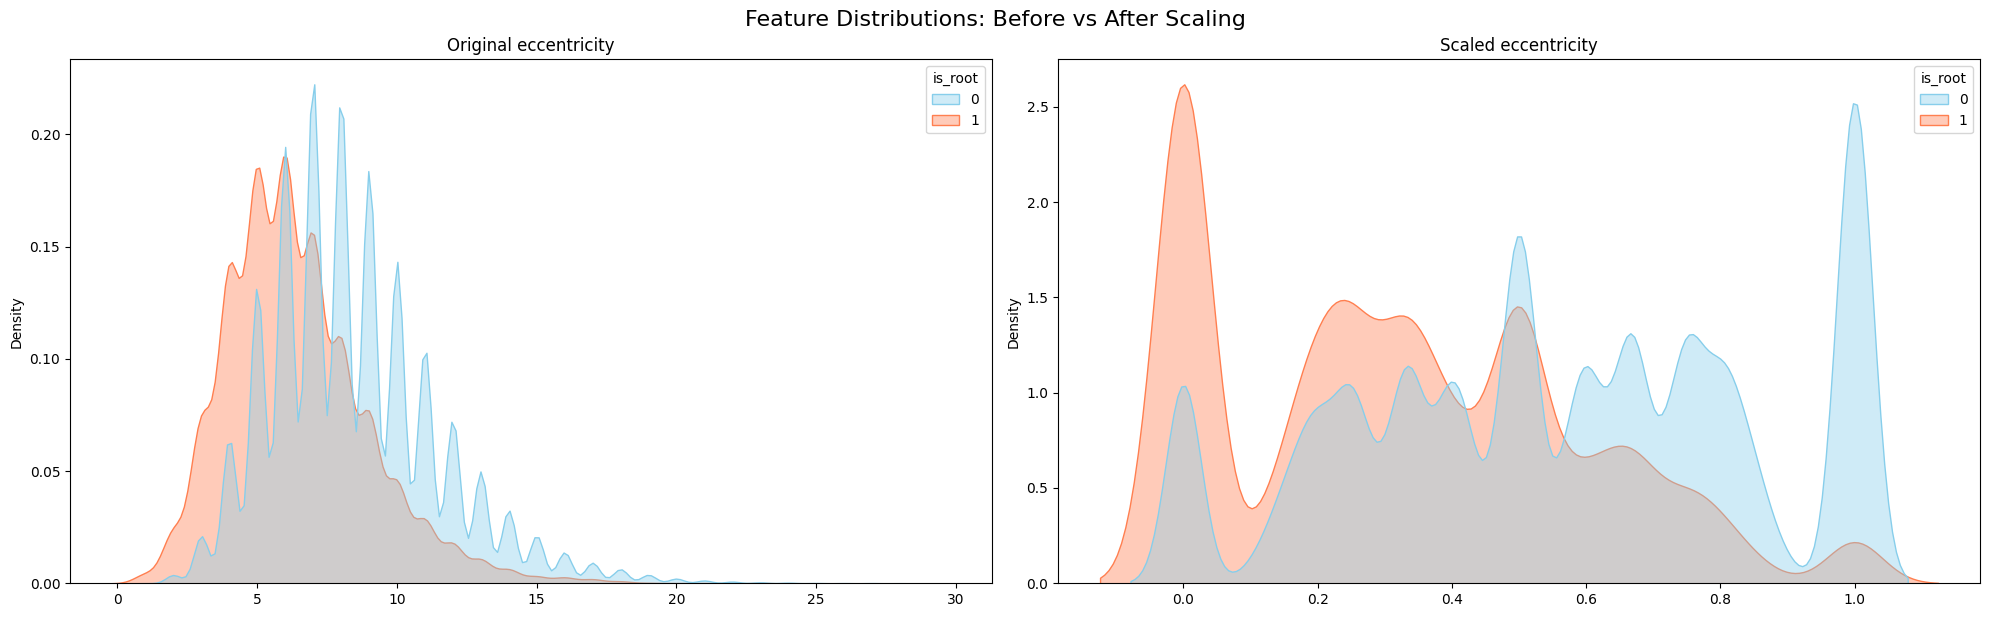

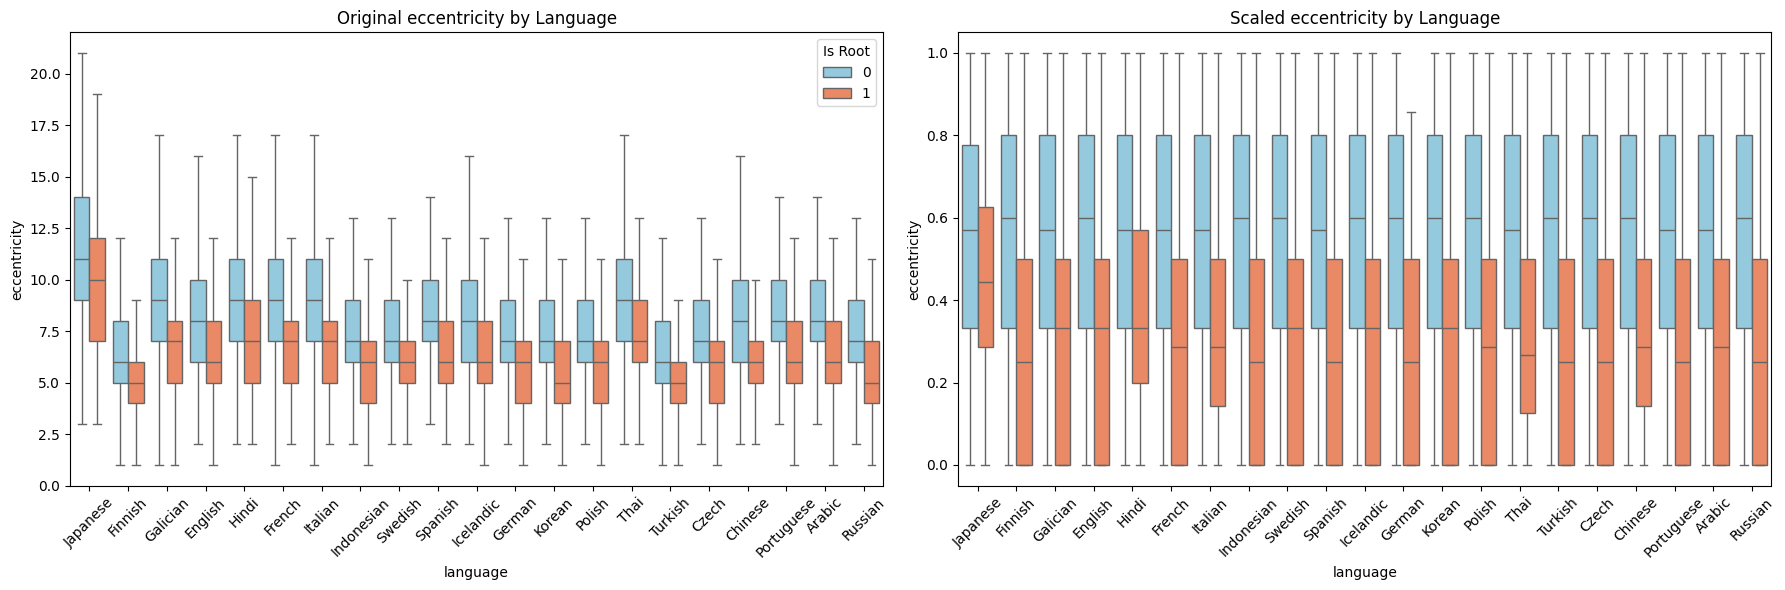

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

def sentence_scale_features(df):
    """Scale features within each sentence group using Robust Scaler"""
    scaled_df = df.copy()
    
    # Get all numeric features
    numeric_cols = scaled_df.select_dtypes(include=[np.number]).columns
    features = [col for col in numeric_cols 
               if col not in ['id', 'n', 'sentence', 'is_root', 'vertex', 'is_articulation']]

    scaled_df[features] = scaled_df[features].astype(float)

    # Group by language and sentence ID
    for (lang, sent), group in scaled_df.groupby(['language', 'sentence']):
        
        # Apply MinMax within each sentence group
        scaler = MinMaxScaler()  
        scaled_values = scaler.fit_transform(group[features])
        scaled_df.loc[group.index, features] = scaled_values

    return scaled_df

def plot_feature_distributions(df, features, title_suffix=""):
    """
    Plot feature distributions with both root/non-root comparisons and language-level analysis
    
    Parameters:
    - df: DataFrame containing features, 'is_root', and 'language' columns
    - features: List of feature names to plot
    - title_suffix: String to append to plot titles
    """
    plt.figure(figsize=(18, 12))
    
    # 1. Root vs Non-root KDE Plots
    for i, feature in enumerate(features, 1):
        plt.subplot(2, len(features), i)
        sns.kdeplot(data=df, x=feature, hue='is_root', 
                    common_norm=False, fill=True, alpha=0.4,
                    palette={0: "skyblue", 1: "coral"})
        plt.title(f'Root vs Non-Root\n{feature}')
        plt.xlabel('')
    
    # 2. Language Comparison Boxplots
    for i, feature in enumerate(features, len(features)+1):
        plt.subplot(2, len(features), i)
        sns.boxplot(x='language', y=feature, hue='is_root', 
                    data=df, showfliers=False,
                    palette={0: "skyblue", 1: "coral"})
        plt.title(f'Language Comparison\n{feature}')
        plt.xlabel('')
        plt.xticks(rotation=45)
        
        # Only show legend on first plot
        if i != len(features)+1:
            plt.legend().remove()
    
    # plt.tight_layout()
    plt.suptitle(f'Feature Distributions {title_suffix}', 
                 y=1.02, fontsize=16)
    plt.show()

def compare_feature_distributions(original_df, scaled_df, features):
    """
    Plot side-by-side comparisons of feature distributions before and after scaling
    
    Parameters:
    - original_df: DataFrame before scaling
    - scaled_df: DataFrame after scaling
    - features: List of feature names to plot
    """
    # Set up the figure
    n_features = len(features)
    plt.figure(figsize=(20, 6*n_features))
    
    # Create subplots - 2 columns (before/after) and n_features rows
    for i, feature in enumerate(features, 1):
        # Original Distribution (Left)
        plt.subplot(n_features, 2, 2*i-1)
        sns.kdeplot(data=original_df, x=feature, hue='is_root',
                   common_norm=False, fill=True, alpha=0.4,
                   palette={0: "skyblue", 1: "coral"})
        plt.title(f'Original {feature}', fontsize=12)
        plt.xlabel('')
        
        # Scaled Distribution (Right)
        plt.subplot(n_features, 2, 2*i)
        sns.kdeplot(data=scaled_df, x=feature, hue='is_root',
                   common_norm=False, fill=True, alpha=0.4,
                   palette={0: "skyblue", 1: "coral"})
        plt.title(f'Scaled {feature}', fontsize=12)
        plt.xlabel('')
    
    plt.tight_layout()
    plt.suptitle('Feature Distributions: Before vs After Scaling', y=1.02, fontsize=16)
    plt.show()

    # Language-specific boxplot comparison
    for feature in features:
        plt.figure(figsize=(18, 6))
        
        # Original Boxplots
        plt.subplot(1, 2, 1)
        sns.boxplot(x='language', y=feature, hue='is_root',
                   data=original_df, showfliers=False,
                   palette={0: "skyblue", 1: "coral"})
        plt.title(f'Original {feature} by Language')
        plt.xticks(rotation=45)
        plt.legend(title='Is Root')
        
        # Scaled Boxplots
        plt.subplot(1, 2, 2)
        sns.boxplot(x='language', y=feature, hue='is_root',
                   data=scaled_df, showfliers=False,
                   palette={0: "skyblue", 1: "coral"})
        plt.title(f'Scaled {feature} by Language')
        plt.xticks(rotation=45)
        plt.legend().remove()
        
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":

    # Run the comparison
    features = ['eccentricity']
    train_processed=pd.read_csv('../data/train_processed.csv')
    # Apply sentence-level scaling
    scaled_df = sentence_scale_features(train_processed)

    # Generate comparison plots
    compare_feature_distributions(train_processed, scaled_df, features)

In [2]:
from sklearn.metrics import roc_auc_score

# For original (unscaled) eccentricity
auc_original = roc_auc_score(train_processed['is_root'], train_processed['eccentricity'])

# For sentence-level scaled eccentricity
auc_scaled = roc_auc_score(scaled_df['is_root'], scaled_df['eccentricity'])

print(f"Original AUC: {auc_original:.4f}, Scaled AUC: {auc_scaled:.4f}")


Original AUC: 0.2963, Scaled AUC: 0.2762


## Undersampling Effect

First, we see that Tomek Links Undersampling did not remove much from the majority class

In [ ]:
from collections import Counter
from imblearn.under_sampling import TomekLinks

# Before applying Tomek Links
print("Original class distribution:", Counter(y))

# Apply Tomek Links
tl = TomekLinks()
X_resampled, y_resampled = tl.fit_resample(X, y)

# After applying Tomek Links
print("Resampled class distribution:", Counter(y_resampled))
print("Original shape:", X.shape)
print("Resampled shape:", X_resampled.shape)


Original class distribution: Counter({np.int64(0): 186979, np.int64(1): 10500})
Resampled class distribution: Counter({np.int64(0): 185528, np.int64(1): 10500})
Original shape: (197479, 10)
Resampled shape: (196028, 10)


Next, we apply RandomUndersampler on a logistic regression model to estimate its effect on performance

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.preprocessing import PowerTransformer, MinMaxScaler, RobustScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import set_config
import numpy as np
import pandas as pd
import optuna
from functools import partial

set_config(transform_output="pandas")
np.random.seed(42)

In [4]:
def create_folds(df, n_folds, group_column):
    """Create folds for GroupKFold cross-validation"""
    df_copy = df.copy()
    df_copy['kfold'] = -1
    y = df_copy['is_root']
    groups = df_copy[group_column]

    kf = GroupKFold(n_splits=n_folds)

    for fold, (train_idx, val_idx) in enumerate(kf.split(X=df_copy, y=y, groups=groups)):
        df_copy.loc[val_idx, 'kfold'] = fold
        
    return df_copy

In [ ]:

def evaluate_model_performance(model, X_with_groups_and_features, y_true, feature_columns_for_model):
    if not isinstance(X_with_groups_and_features, pd.DataFrame):
        raise ValueError("X_with_groups_and_features must be a pandas DataFrame for this scorer version.")

    # Make predictions using only the specified feature columns
    X_for_predict = X_with_groups_and_features[feature_columns_for_model]
    try:
        proba_values = model.predict_proba(X_for_predict)[:, 1]
    except Exception as e:
        print(f"Error during predict_proba in evaluation: {e}")
        return {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, {}

    # Add probabilities to a copy of the DataFrame
    df_copy = X_with_groups_and_features.copy()
    df_copy['__proba__'] = proba_values

    # Initialize predictions
    y_pred = pd.Series(np.zeros(len(df_copy)), index=df_copy.index)
    group_cols = ['language', 'sentence']

    # Ensure one root per sentence
    for _, group_df in df_copy.groupby(group_cols):
        if not group_df.empty:
            if '__proba__' in group_df.columns:
                idx_max = group_df['__proba__'].idxmax()
                y_pred.loc[idx_max] = 1
            else:
                print(f"Warning: '__proba__' column missing in group_df during evaluation.")

    # Calculate overall metrics
    overall_metrics = {
        'precision': precision_score(y_true.values, y_pred.values),
        'recall': recall_score(y_true.values, y_pred.values),
        'f1': f1_score(y_true.values, y_pred.values)

    }

    # Calculate per-language metrics
    per_language_metrics = {}
    for lang in X_with_groups_and_features['language'].unique():
        lang_mask = X_with_groups_and_features['language'] == lang
        lang_true = y_true[lang_mask]
        lang_pred = y_pred[lang_mask]
        
        # Only calculate metrics if there are samples for this language
        if len(lang_true) > 0:
            per_language_metrics[lang] = {
                'precision': precision_score(lang_true, lang_pred),
                'recall': recall_score(lang_true, lang_pred),
                'f1': f1_score(lang_true, lang_pred)
            }

    return overall_metrics, per_language_metrics

In [12]:
from imblearn.under_sampling import RandomUnderSampler
train_data=pd.read_csv('../data/train_random_processed.csv')
n_folds = 4
df_with_folds = create_folds(train_data, n_folds, group_column='sentence')

# Use the last fold as validation set
val_fold = n_folds - 1
df_train = df_with_folds[df_with_folds.kfold != val_fold].reset_index(drop=True)
df_valid = df_with_folds[df_with_folds.kfold == val_fold].reset_index(drop=True)

X_valid = df_valid.drop(columns=['is_root', 'kfold'])
y_valid = df_valid['is_root']
X_train = df_train.drop(columns=['is_root', 'kfold'])
y_train = df_train['is_root']

# Best parameters with C > 1
best_model = LogisticRegression(
    C=99.86981387827636, 
    penalty='l2',
    solver='liblinear',
    class_weight={0: 1, 1: 10},
    max_iter=1000
)
best_model2 = LogisticRegression(
    C=99.86981387827636, 
    penalty='l2',
    solver='liblinear',
    class_weight={0: 1, 1: 10},
    max_iter=1000
)

feature_columns=['closeness', 'degree', 'pagerank',
                 'is_articulation', 'betweenness', 'eigencentrality', 'eccentricity', 'is_japanese',
        'lang_group_head_final_sov', 'lang_group_romance_svo', 'lang_group_germanic_v2', 'lang_group_free_order_case', 'lang_group_analytic']

rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)
best_model.fit(X_train_res[feature_columns], y_train_res)
best_model2.fit(df_train[feature_columns], df_train['is_root'])


# Evaluate on validation set
print("\nModel Performance (Validation Set):")
overall_metrics, per_language_metrics = evaluate_model_performance(
    best_model, 
    X_valid, 
    y_valid,
    feature_columns
)
overall_metrics2, per_language_metrics2 = evaluate_model_performance(
    best_model2, 
    X_valid, 
    y_valid,
    feature_columns
)

print("\nThe effect of RandomUndersampler on performance:")
print(f"F1 Score before: {overall_metrics2['f1']:.4f}\nF1 Score after: {overall_metrics['f1']:.4f}")



Model Performance (Validation Set):

The effect of RandomUndersampler on performance:
F1 Score before: 0.2971
F1 Score after: 0.2949


## Features' separation of root and non-root nodes in each language

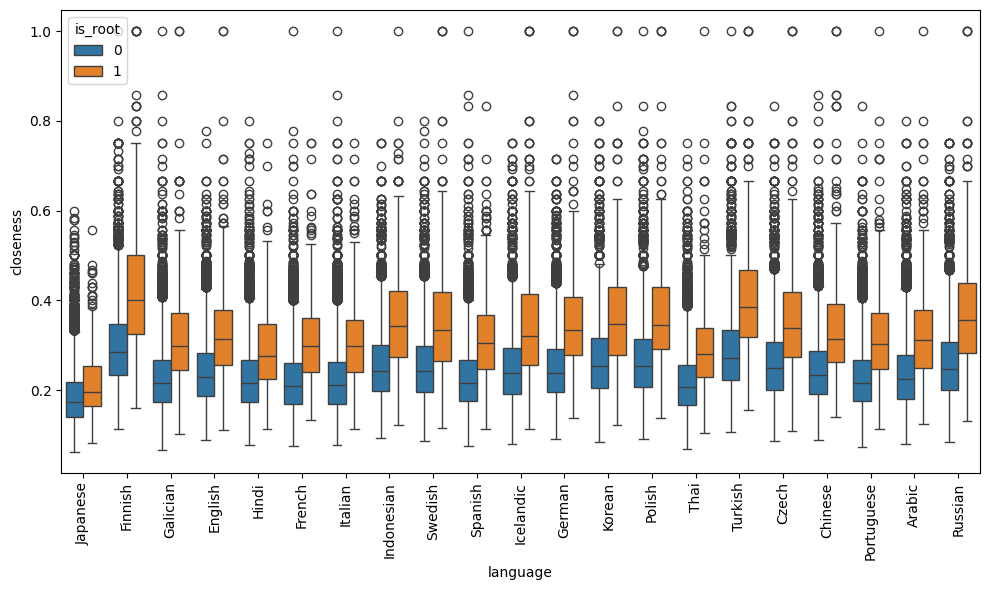

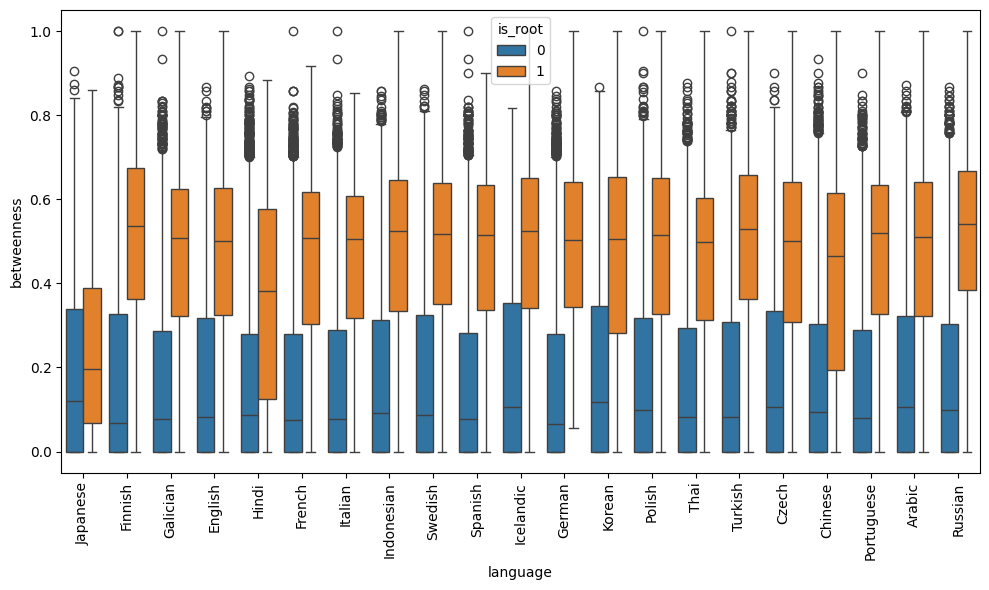

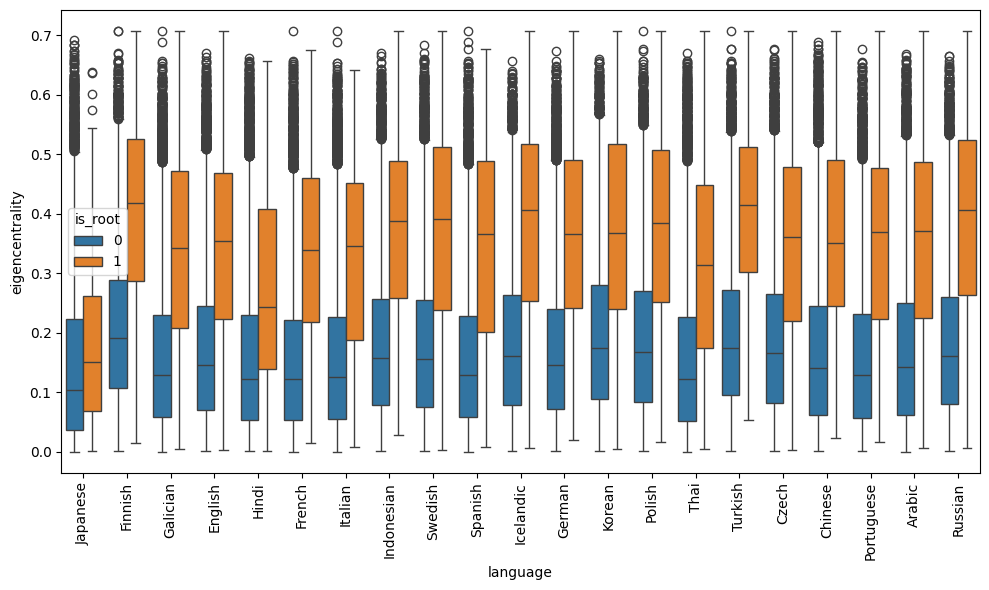

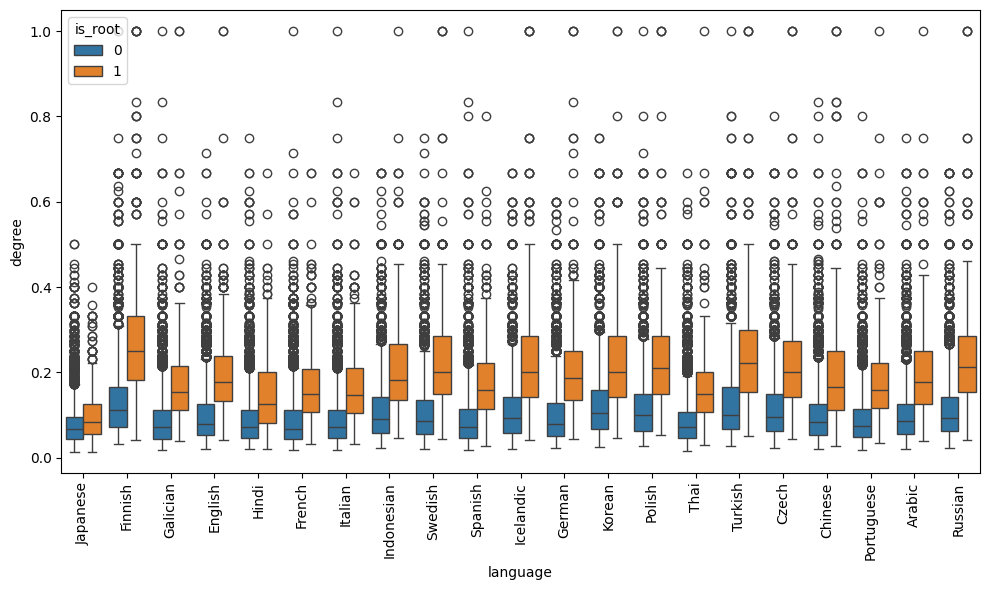

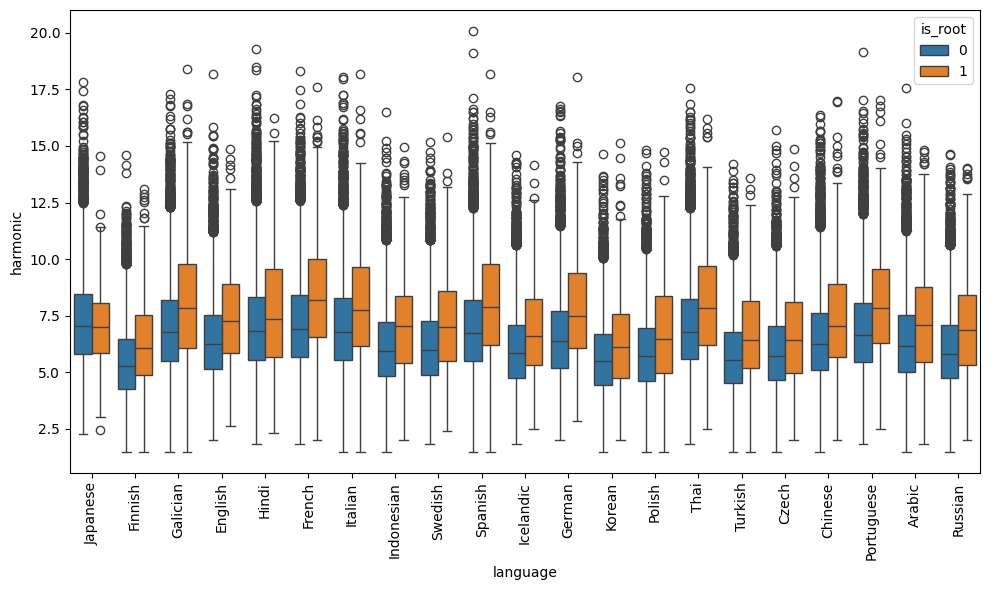

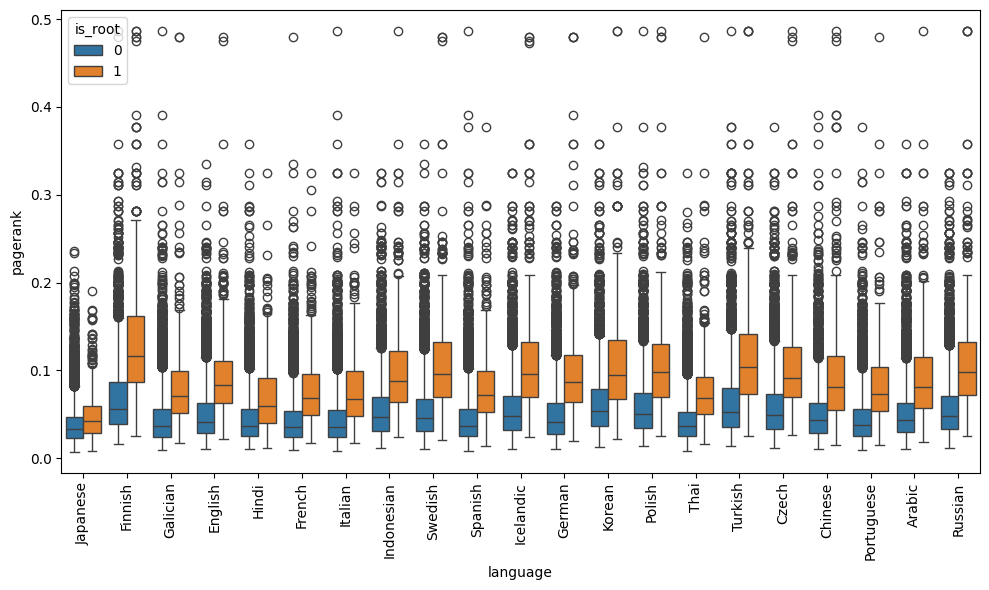

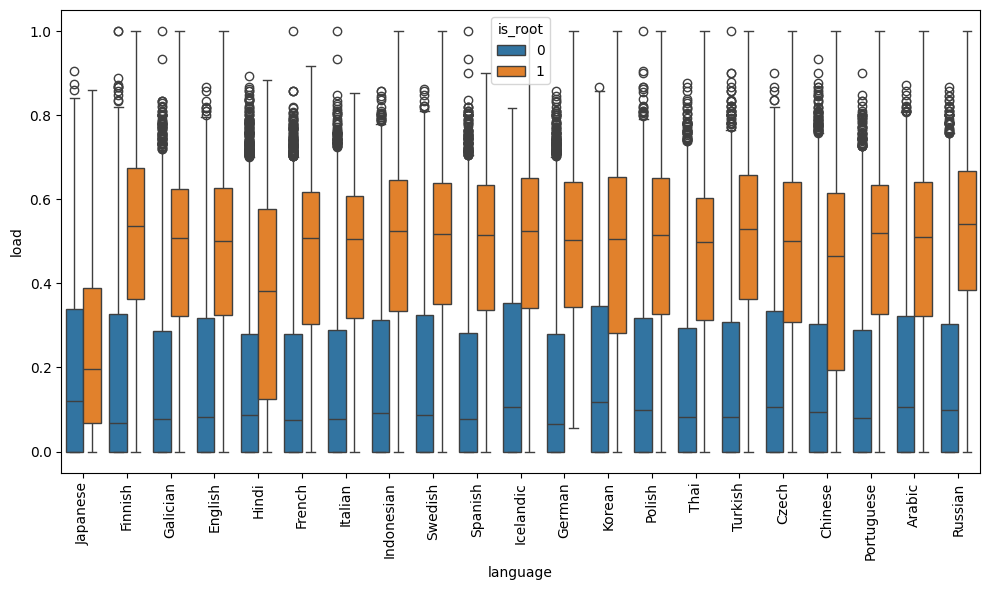

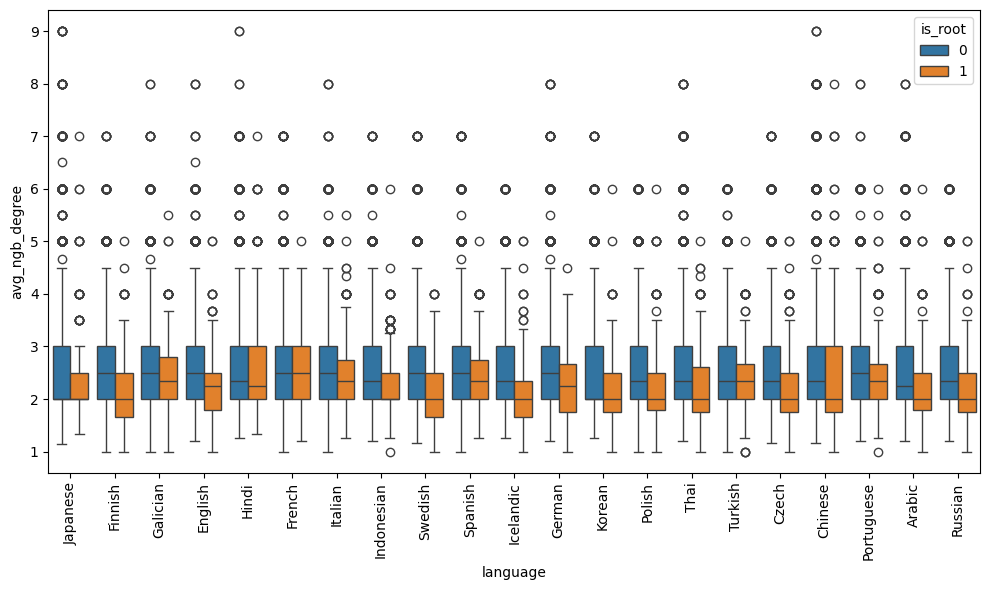

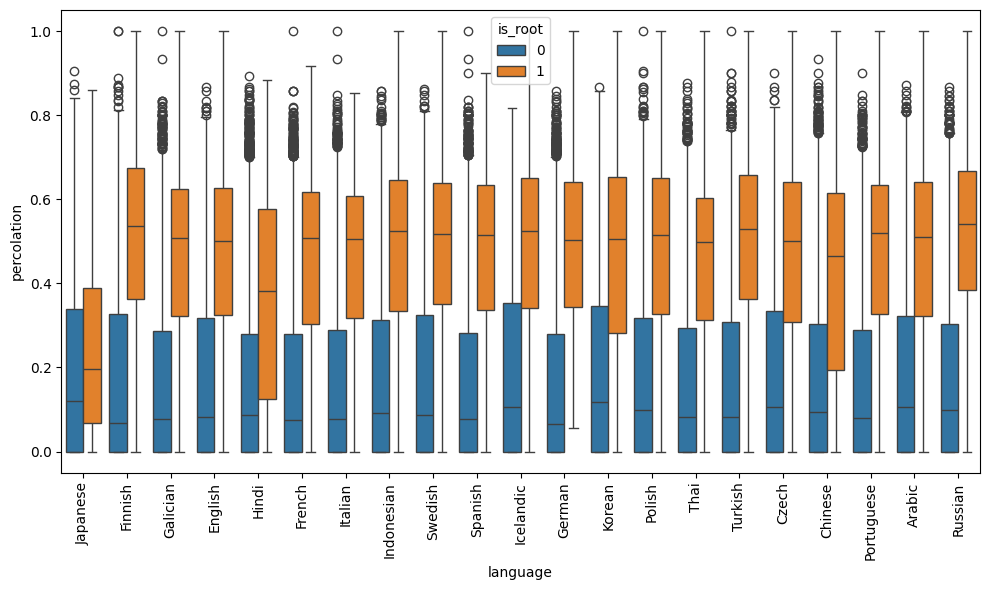

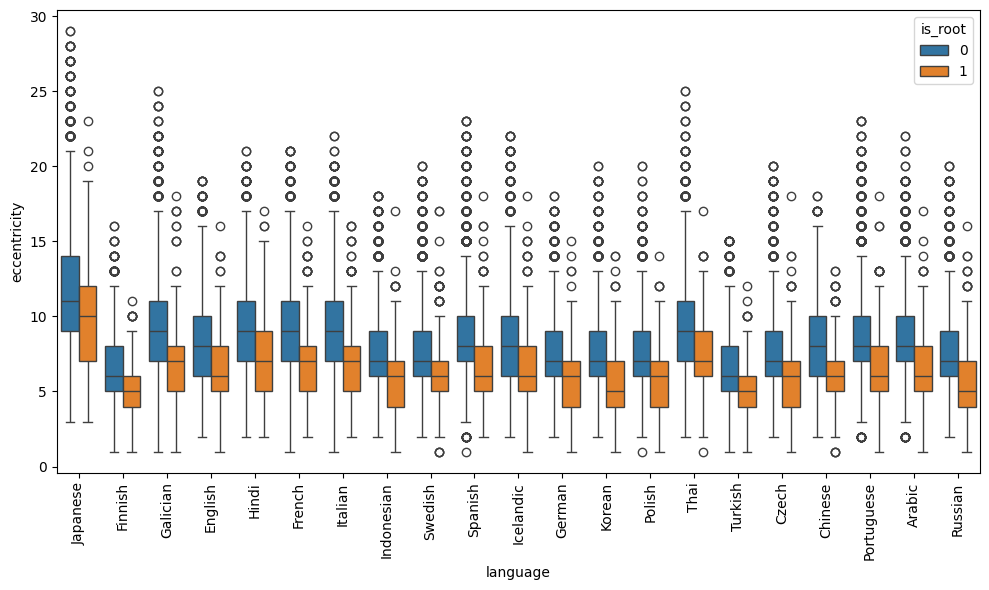

In [ ]:
import seaborn as sns

features = ['closeness', 'betweenness', 'eigencentrality', 'degree', 'harmonic', 'pagerank', 'load', 'avg_ngb_degree', 'percolation', 'eccentricity']
for feature in features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='language', y=feature, hue='is_root', data=expanded_dataset)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

For comparison we can look at how the feature based on directed graph (such as subtree size per node) separates the classes in each language

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

X = merged_df[['subtree_size_scaled']]
y = merged_df['is_root']

model = LogisticRegression()
model.fit(X, y)

# Predict probabilities for AUC-ROC
y_pred_proba = model.predict_proba(X)[:, 1]
print("ROC-AUC Score:", roc_auc_score(y, y_pred_proba))

# Classification report
print(classification_report(y, model.predict(X)))

ROC-AUC Score: 0.960311562108197
              precision    recall  f1-score   support

           0       0.96      0.99      0.98    186979
           1       0.61      0.32      0.42     10500

    accuracy                           0.95    197479
   macro avg       0.79      0.65      0.70    197479
weighted avg       0.94      0.95      0.95    197479



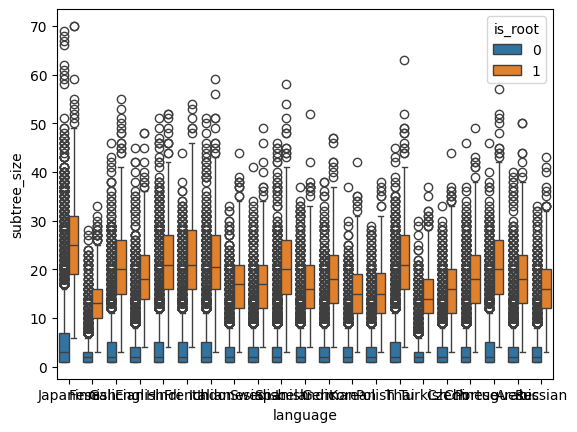

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=merged_df, x='language', y='subtree_size', hue='is_root')
plt.set_titles("{col_name}")
plt.show()

## Other explorations

### Sentence count per range of node_count
Here we first create the bins with ranges based on the number of words / nodes. Then calculate the number of sentences in each such range overall and per language.

In [ ]:
import pandas as pd

# Define the bins
bins = [0, 3, 6, 10, 20, 30, 50, 70]
labels = ['0-3', '3-6', '6-10', '11-20', '21-30', '31-50', '51-70']

# Create a new column that puts each row into a bin
train_data['n_bin'] = pd.cut(train_data['n'], bins=bins, labels=labels, right=True)

# Count number of sentences per bin
bin_counts = train_data['n_bin'].value_counts().sort_index()

# print("Number of sentences per node_count range:")
# print(bin_counts)

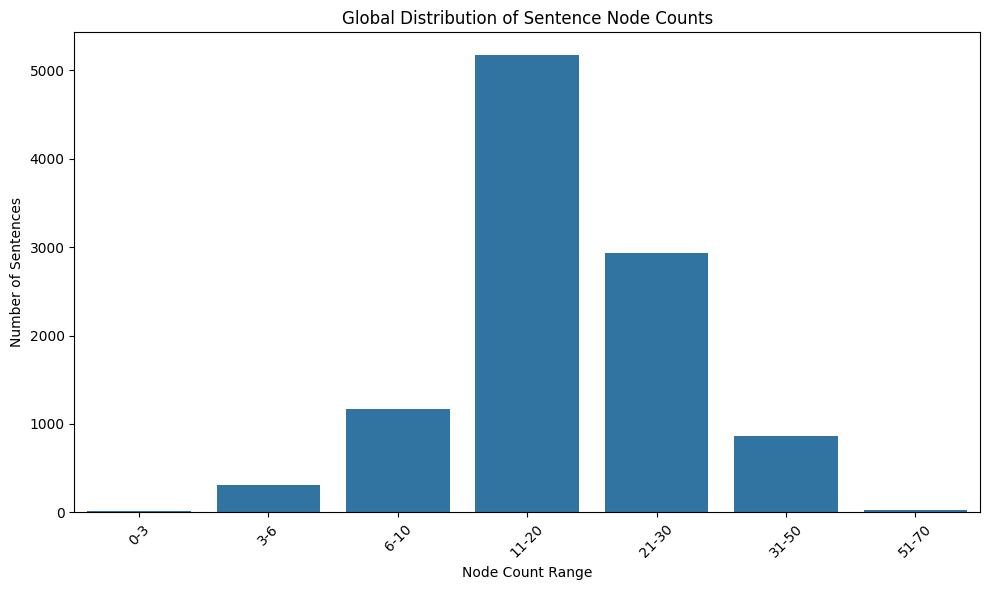

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=train_data, x='n_bin', order=labels)
plt.title("Global Distribution of Sentence Node Counts")
plt.xlabel("Node Count Range")
plt.ylabel("Number of Sentences")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# train_data.groupby('language')['n_bin'].value_counts().unstack(fill_value=0)

/var/folders/0r/x2rt66gj2h75vp5rrm7772br0000gn/T/ipykernel_5264/3871134639.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lang_bin_counts = train_data.groupby(['language', 'n_bin']).size().unstack(fill_value=0)[labels]


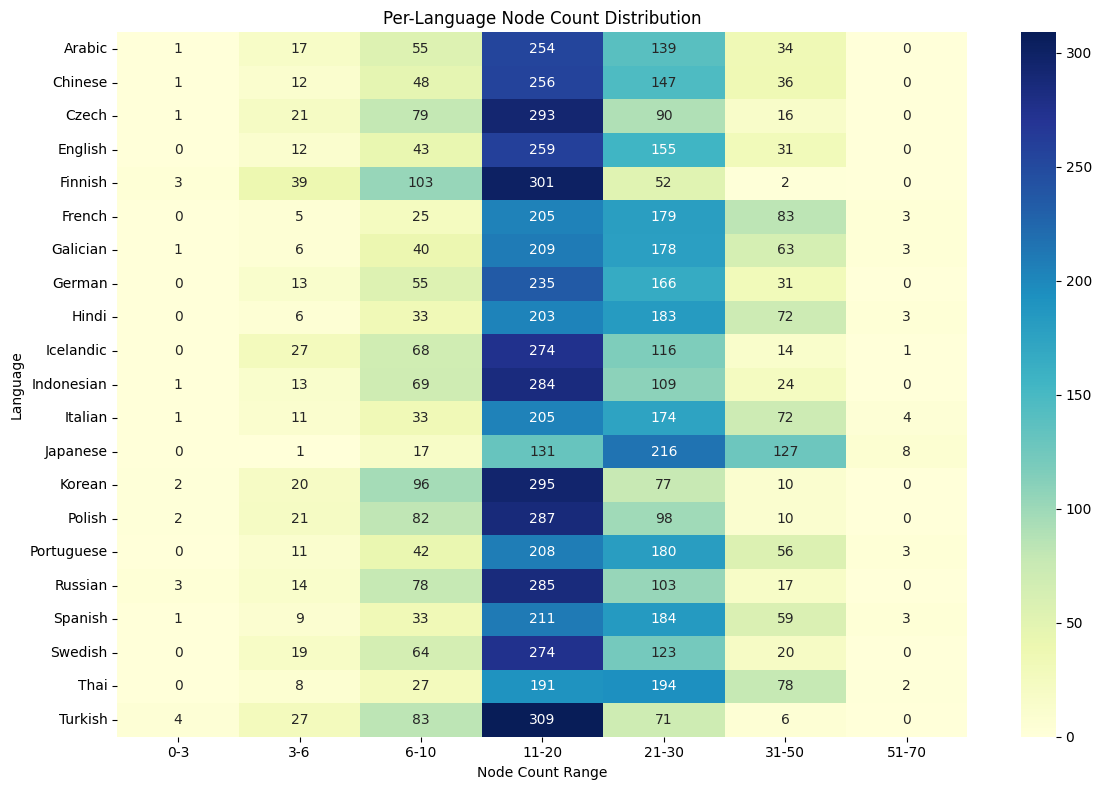

In [ ]:
# Count sentences per bin per language
lang_bin_counts = train_data.groupby(['language', 'n_bin']).size().unstack(fill_value=0)[labels]

plt.figure(figsize=(12, 8))
sns.heatmap(lang_bin_counts, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Per-Language Node Count Distribution")
plt.xlabel("Node Count Range")
plt.ylabel("Language")
plt.tight_layout()
plt.show()


# Load data and create final features

In [2]:

class CentralityFeatures(BaseEstimator, TransformerMixin):
    """Class to compute centrality features for nodes in a graph"""
    
    def __init__(self, is_test=False):
        self.is_test = is_test
        self.feature_names = [
            'degree', 'closeness', 'harmonic','load', 'betweenness', 
            'pagerank', 'eigencentrality','eccentricity',
            'is_articulation', 'avg_neighbor_degree'
        ]
    
    def _compute_centralities(self, edgelist):
        """Compute all centrality metrics for a graph"""
        T = nx.from_edgelist(edgelist)
        
        dc = nx.degree_centrality(T)
        cc = nx.closeness_centrality(T)
        hc = nx.harmonic_centrality(T)
        lc=nx.load_centrality(T)
        bc = nx.betweenness_centrality(T)
        pr = nx.pagerank(T)
        ec = nx.eigenvector_centrality(T, max_iter=1000, tol=1e-04)
        et = nx.eccentricity(T)
        ap = list(nx.articulation_points(T))
        ad = nx.average_neighbor_degree(T)
        
        return {v: (dc[v], cc[v], hc[v], lc[v], bc[v], pr[v], ec[v], 
                    et[v], 1 if v in ap else 0, ad[v]) 
                for v in T}
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        """X should be a DataFrame with columns: ['language', 'sentence', 'edgelist', 'root']"""
        all_rows = []
        
        for _, row in X.iterrows():
            language = row['language']
            sentence_id = row['sentence']
            n = row['n']  
            edgelist = ast.literal_eval(row['edgelist'])
            root = int(row['root']) if not self.is_test else None
            cent_dict = self._compute_centralities(edgelist)
            
            for vertex, features in cent_dict.items():
                row_data = {
                    'language': language,
                    'sentence': sentence_id,
                    'n': n,
                    'vertex': vertex,
                }
                if self.is_test:
                    row_data['id'] = row['id']
                else:
                    row_data['is_root'] = 1 if vertex == root else 0
                
                row_data['edgelist'] = row['edgelist']
                # Add all centrality features
                row_data.update(zip(self.feature_names, features))
                all_rows.append(row_data)
        
        return pd.DataFrame(all_rows)

class AdvancedTreeFeatures(BaseEstimator, TransformerMixin):
    """Advanced tree-specific features beyond centrality measures"""
    
    def __init__(self):
        self.feature_names = ['tree_balance', 'balance_variance', 'path_asymmetry', 'diameter_path', 'large_comp', 'comp_count']
    
    def _compute_tree_balance(self, G, node):
        """
        Computes how balanced the resulting components would be if this node
        were the root. A more balanced split suggests a central/root-like node.
        """
        G_removed = G.copy()
        G_removed.remove_node(node)
        
        # Get sizes of components that would be subtrees if node was root
        components = list(nx.connected_components(G_removed))
        component_sizes = [len(c) for c in components]
        
        if not component_sizes:  # Leaf node
            return 0, 0
        
        total_nodes = sum(component_sizes)
        
        # Perfect balance would be all components equal size
        # Calculate how close we are to perfect balance (1 = perfect, 0 = terrible)
        ideal_size = total_nodes / max(1, len(component_sizes))
        
        # Calculate normalized deviation from perfect balance
        # 1 - (avg deviation / ideal) gives us balance score between 0-1
        deviations = [abs(size - ideal_size) for size in component_sizes]
        avg_deviation = sum(deviations) / len(deviations)
        balance_score = 1 - min(1, avg_deviation / max(1, ideal_size))
        
        # Calculate variance of component sizes
        # Lower variance = more balanced
        if len(component_sizes) > 1:
            balance_variance = np.var(component_sizes) / (total_nodes ** 2)
        else:
            balance_variance = 0
        
        return balance_score, balance_variance
    
    def _component_count(self, G, node):
        """Number of components created when removing this node"""
        if not G.has_node(node):
            return 0
            
        G_copy = G.copy()
        G_copy.remove_node(node)
        
        return nx.number_connected_components(G_copy)
    
    def _compute_path_asymmetry(self, G, node):
        """
        Measures how uneven the path lengths are from this node.
        Low asymmetry suggests central/root position.
        """
        # Get all shortest paths from this node
        distances = dict(nx.single_source_shortest_path_length(G, node))
        path_lengths = list(distances.values())
        
        if len(path_lengths) <= 1:  # Only self
            return 0, False
            
        # Calculate variance as a measure of asymmetry
        # Normalize by square of max path length to bound it
        max_path = max(path_lengths)
        if max_path > 0:
            asymmetry = np.var(path_lengths) / (max_path ** 2)
        else:
            asymmetry = 0
            
        # Check if this node is on the diameter path (longest path in graph)
        # First find the diameter efficiently
        # For trees, we can use a shortcut: find furthest node from any node,
        # then find furthest node from that
        u = max(distances.items(), key=lambda x: x[1])[0]  # Furthest from node
        furthest_from_u = dict(nx.single_source_shortest_path_length(G, u))
        v = max(furthest_from_u.items(), key=lambda x: x[1])[0]
        
        # Check if our node is on the path from u to v
        try:
            diameter_path = nx.shortest_path(G, u, v)
            on_diameter = node in diameter_path
        except:
            on_diameter = False
            
        return asymmetry, on_diameter
    def _largest_remaining_component(self, G, node):
        """Size of the largest component after removing this node"""
        if not G.has_node(node):
            return 0
            
        # Create a copy and remove the node
        G_copy = G.copy()
        G_copy.remove_node(node)
        
        # Find the largest remaining component
        if nx.number_of_nodes(G_copy) > 0:
            components = list(nx.connected_components(G_copy))
            return max(len(c) for c in components) if components else 0
        else:
            return 0
    def _compute_features(self, edgelist, vertex):
        edges = ast.literal_eval(edgelist)
        G = nx.Graph(edges)  # Undirected graph
        
        if not G.has_node(vertex):
            return [0, 0, 0, 0]
        
        # Calculate tree balance features
        balance_score, balance_variance = self._compute_tree_balance(G, vertex)
        
        # Calculate path asymmetry features
        asymmetry, on_diameter = self._compute_path_asymmetry(G, vertex)

        component_count = self._component_count(G,vertex)
        large_comp = self._largest_remaining_component(G, vertex)
        
        return [
            balance_score,            # Higher = more balanced split (good for root)
            balance_variance,         # Lower = more balanced (good for root)
            asymmetry,                # Lower = more symmetric paths (good for root)
            1 if on_diameter else 0,   # Is the node on the diameter path?
            large_comp,
            component_count
        ]
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        results = []
        
        for _, row in X.iterrows():
            features = self._compute_features(
                row['edgelist'], 
                row['vertex']
            )
            results.append(pd.Series(features, index=self.feature_names))
        
        return pd.concat(results, axis=1).transpose()
    
class InteractionFeatures(BaseEstimator, TransformerMixin):
    """Class to compute interaction features between graph metrics"""
    
    def __init__(self):
        self.feature_names = [
            'betweenness_degree',
            'betweenness_closeness',
            'eigencentrality_degree',
            'eigencentrality_betweenness',
            'degree_closeness',
            'degree_eccentricity'
        ]
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        """Create interaction features from existing graph metrics"""
        X = X.copy()
        
        # Create interaction terms
        X['betweenness_degree'] = X['betweenness'] * X['degree']
        X['betweenness_closeness'] = X['betweenness'] * X['closeness']
        X['eigencentrality_degree'] = X['eigencentrality'] * X['degree']
        X['eigencentrality_betweenness'] = X['eigencentrality'] * X['betweenness']
        X['degree_closeness'] = X['degree'] * X['closeness']
        X['degree_eccentricity'] = X['degree'] * X['eccentricity']
        
        return X
    
class GraphFeaturePipeline(BaseEstimator, TransformerMixin):
    def __init__(self, is_test=False):
        self.is_test = is_test
        self.centrality = CentralityFeatures(is_test=self.is_test)
        self.advanced_tree = AdvancedTreeFeatures()
        self.interaction = InteractionFeatures()
    @staticmethod
    def add_language_groups(df):
        # Create mapping
        language_groups = {
            'head_final_sov': ['Japanese', 'Korean', 'Turkish'],
            'romance_svo': ['Spanish', 'Portuguese', 'French', 'Italian', 'Galician'],
            'germanic_v2': ['German', 'Swedish', 'Icelandic'],
            'free_order_case': ['Russian', 'Polish', 'Czech', 'Finnish'],
            'analytic': ['English', 'Chinese', 'Thai', 'Indonesian'],
            'other': ['Arabic', 'Hindi']  # Languages with unique structures
        }
        
        # Add group features
        for group, languages in language_groups.items():
            df[f'lang_group_{group}'] = df['language'].isin(languages).astype(int)
        
        return df
    def fit(self, X, y=None):
        if not self.is_test:
            self.centrality.fit(X)
            self.advanced_tree.fit(X)  # Not really needed but following pattern
        return self
    
    def transform(self, X):
        centrality_df = self.centrality.transform(X)
        advanced_tree_df = self.advanced_tree.transform(centrality_df)
        combined_df = pd.concat([centrality_df, advanced_tree_df], axis=1)
        
        # Drop 'edgelist' column from final output if needed
        if 'edgelist' in combined_df.columns:
            combined_df = combined_df.drop(columns=['edgelist'])
            
        # Add interaction features
        interaction_df = self.interaction.transform(combined_df)
        combined_df = pd.concat([combined_df, interaction_df[self.interaction.feature_names]], axis=1)
        combined_df['is_japanese'] = (combined_df['language'] == 'Japanese').astype(int)
        # is_articulation (structural) with graph metrics
        combined_df['articulation_degree'] = combined_df['is_articulation'] * combined_df['degree']  # Nodes with high degree that are articulation points
        combined_df['articulation_betweenness'] = combined_df['is_articulation'] * combined_df['betweenness']  # Articulation points with high betweenness

        # is_japanese with structural features
        combined_df['japanese_articulation'] = combined_df['is_japanese'] * combined_df['is_articulation']  # Japanese-specific articulation points
        combined_df['japanese_betweenness'] = combined_df['is_japanese'] * combined_df['betweenness']  # Japanese-specific betweenness patterns
        combined_df=self.add_language_groups(combined_df)
        return combined_df

In case of errors, please change the directory of the files accordingly below

In [ ]:
train = pd.read_csv('../data/train-random.csv')
pipeline = GraphFeaturePipeline()
train_data = pipeline.fit_transform(train)
train_data.to_csv('../data/train_random_processed.csv', index=False)
print(f'Train Data: {train_data.head(10)}')
test = pd.read_csv('../data/test-random.csv')
pipeline = GraphFeaturePipeline(is_test=True)
test_data = pipeline.transform(test)
test_data.to_csv('../data/test_random_processed.csv', index=False)
print(f'Test Data: {test_data.head(10)}')

# Alternatively load here (faster)

In [5]:
train_data=pd.read_csv('../data/train_random_processed.csv')
test_data=pd.read_csv('../data/test_random_processed.csv')

# Check collinearity heatmap (optional)

Define the needed features

In [ ]:
all_features = ['closeness', 'degree', 'pagerank', 'eigencentrality', 'eccentricity', 'betweenness','vertex','n', 'is_articulation', 'avg_neighbor_degree', 'tree_balance', 'balance_variance', 'diameter_path', 'path_asymmetry', 'harmonic', 'load', 'comp_count', 'is_japanese']

In [ ]:
check_df = train_data[all_features]
check_df['target'] = train_data['is_root']

Plot the heatmap

In [ ]:

corr = check_df.corr()
plt.figure(figsize=(10,8))

mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
                center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Feature Correlation Matrix")
plt.show()

# Hyperparameter Tuning

For customised learning, first we define the function that forces one root per sentence and derives the F1-score between prediction and true value. The node with the highest probability is labeled as a root.

In [ ]:
def one_root_f1_scorer(estimator, X_with_groups_and_features, y_true, feature_columns_for_model):
    """Custom scorer. X_with_groups_and_features should be a pandas DataFrame containing
       both group columns ('language', 'sentence') and the feature_columns_for_model."""

    if not isinstance(X_with_groups_and_features, pd.DataFrame):
        raise ValueError("X_with_groups_and_features must be a pandas DataFrame for this scorer version.")

    # Make predictions using only the specified feature columns
    X_for_predict = X_with_groups_and_features[feature_columns_for_model]
    try:
        proba_values = estimator.predict_proba(X_for_predict)[:, 1]
    except Exception as e:
        print(f"Error during predict_proba in scorer: {e}. Columns expected: {feature_columns_for_model}, Columns in X_for_predict: {X_for_predict.columns.tolist() if isinstance(X_for_predict, pd.DataFrame) else 'N/A (NumPy)'}")
        return 0.0 # Return a score that indicates failure

    # Add probabilities to a copy of the DataFrame to use its index for grouping and selection
    df_copy = X_with_groups_and_features.copy()
    df_copy['__proba__'] = proba_values

    y_pred = pd.Series(np.zeros(len(df_copy)), index=df_copy.index)
    group_cols = ['language', 'sentence']

    for _, group_df in df_copy.groupby(group_cols):
        if not group_df.empty:
            if '__proba__' in group_df.columns:
                idx_max = group_df['__proba__'].idxmax()
                y_pred.loc[idx_max] = 1
            else:
                # This case should not happen if proba_values were assigned correctly
                print(f"Warning: '__proba__' column missing in group_df during scoring.")
    
    # Ensure y_true and y_pred are numpy arrays for f1_score to avoid potential index issues
    return f1_score(y_true.values, y_pred.values)

Then we define the function that creates folds ensuring that sentence ids from different languages do not end up in different folds, thus preventing leakage.

In [ ]:
def create_folds(df, n_folds, group_column):
    """Create folds for GroupKFold cross-validation"""
    df_copy = df.copy()
    df_copy['kfold'] = -1
    y = df_copy['is_root']
    groups = df_copy[group_column]

    kf = GroupKFold(n_splits=n_folds)

    for fold, (train_idx, val_idx) in enumerate(kf.split(X=df_copy, y=y, groups=groups)):
        df_copy.loc[val_idx, 'kfold'] = fold
        
    return df_copy

Next, we define the function used for each fold, which divides train and validation sets, applies the model passed in arguments, fits the model to train set and checks the score with custom scoring function on validation set.

In [ ]:
from sklearn.base import clone

def run_model(df_with_folds, fold, estimator, params, feature_columns, feature_pipeline=None, trial=None):
    """Run model training and evaluation for a single fold."""
    df_train = df_with_folds[df_with_folds.kfold != fold].reset_index(drop=True)
    df_valid = df_with_folds[df_with_folds.kfold == fold].reset_index(drop=True)

    X_train_original = df_train.drop(columns=['is_root', 'kfold'])
    X_valid_original = df_valid.drop(columns=['is_root', 'kfold'])
    y_train = df_train['is_root']
    y_valid = df_valid['is_root']

    X_train_processed = X_train_original
    X_valid_processed = X_valid_original
    
    current_feature_columns = list(feature_columns)

    if feature_pipeline:
        X_train_processed = feature_pipeline.fit_transform(X_train_original)
        X_valid_processed = feature_pipeline.transform(X_valid_original)
        
        if not isinstance(X_train_processed, pd.DataFrame) and hasattr(feature_pipeline, 'get_feature_names_out'):
            try:
                current_feature_columns = feature_pipeline.get_feature_names_out()
                X_train_processed = pd.DataFrame(X_train_processed, columns=current_feature_columns)
                X_valid_processed = pd.DataFrame(X_valid_processed, columns=current_feature_columns)
            except Exception as e:
                if trial: trial.set_user_attr(f'fold_{fold}_feature_pipeline_error', str(e))
                print(f"Fold {fold} error getting feature names from pipeline: {e}")
                return float('nan')
        elif not isinstance(X_train_processed, pd.DataFrame):
            X_train_processed = pd.DataFrame(X_train_processed, columns=feature_columns)
            X_valid_processed = pd.DataFrame(X_valid_processed, columns=feature_columns)

    model = clone(estimator)
    model.set_params(**params)
    
    try:
        model.fit(X_train_processed[current_feature_columns], y_train)
    except Exception as e:
        if trial: trial.set_user_attr(f'fold_{fold}_fit_error', str(e))
        print(f"Fold {fold} model fitting failed: {str(e)}. Features used: {current_feature_columns}")
        return float('nan')

    try:
        score = one_root_f1_scorer(
            model,
            X_valid_processed,
            y_valid,
            feature_columns_for_model=current_feature_columns
        )
    except Exception as e:
        if trial: trial.set_user_attr(f'fold_{fold}_score_error', str(e))
        print(f"Fold {fold} scoring failed: {str(e)}")
        return float('nan')
        
    return score

Objective functions will be defined further for each model

## Scaling pipeline (for Logistic Regression)

In [ ]:
from sklearn import set_config
set_config(transform_output="pandas")

class SentenceGroupScaler(BaseEstimator, TransformerMixin):
    def __init__(self, features_to_scale, group_columns=['language', 'sentence']):
        self.features_to_scale = features_to_scale
        self.group_columns = group_columns
        
    def fit(self, X, y=None):
        # No need to store anything
        return self
    
    def transform(self, X):
        X = X.copy()
        X[self.features_to_scale] = X[self.features_to_scale].astype(np.float64)
        
        for _, group_df in X.groupby(self.group_columns):
            group_idx = group_df.index
            scaler = MinMaxScaler()
            X.loc[group_idx, self.features_to_scale] = scaler.fit_transform(
                group_df[self.features_to_scale]
            )
        return X
    
    def fit_transform(self, X, y=None):
        return self.transform(X)
    def set_output(self, *, transform=None):
        self._output_config = transform
        return self
    
def create_feature_pipeline(sentence_scaled_features):
    # Create individual transformers
    
    return Pipeline([
        ('sentence_scale', SentenceGroupScaler(
            features_to_scale=sentence_scaled_features
     )),
        # ('global_scale', global_scaler)
    ])

## Logistic Regression

In [ ]:
def objective(trial, df, feature_columns, feature_pipeline=None):
    try:
        # First decide which configuration to use
        # config_type = trial.suggest_categorical('config_type', ['l1_l2', 'elasticnet'])
        config_type = trial.suggest_categorical('config_type', ['l1_l2'])
        
        class_weight_option = trial.suggest_categorical('class_weight', ['balanced', 'custom'])
        class_weight = {0: 1, 1: 10} if class_weight_option == 'custom' else 'balanced'

        if config_type == 'l1_l2':
            params = {
                'penalty': trial.suggest_categorical('penalty', ['l1','l2']),
                'C': trial.suggest_float('C', 0.0000001, 100, log=True),
                'solver': trial.suggest_categorical('solver', ['liblinear', 'saga']),
                'class_weight': class_weight,
                'max_iter': 2000,
                'random_state': 42
            } 
        else:  # elasticnet
            params = {
                'penalty': 'elasticnet',
                'C': trial.suggest_float('C', 0.0000001, 0.01, log=True),
                'solver': 'saga',
                'l1_ratio': trial.suggest_float('l1_ratio', 0.1, 0.9),
                'class_weight': 'balanced',
                'max_iter': 1000,
                'random_state': 42
            }
        
        n_folds = 4
        df_with_folds = create_folds(df, n_folds, group_column='sentence')
        scores = []

        for fold in range(n_folds):
            trial.set_user_attr(f'fold_{fold+1}_status', 'starting')
            try:
                score = run_model(
                    df_with_folds, 
                    fold, 
                    LogisticRegression(), 
                    params, 
                    feature_columns, 
                    feature_pipeline, 
                    trial=trial
                )
                
                if np.isnan(score):
                    trial.set_user_attr(f'fold_{fold+1}_status', 'returned_nan')
                    print(f"Trial {trial.number} Fold {fold+1} returned NaN.")
                else:
                    scores.append(score)
                    trial.set_user_attr(f'fold_{fold+1}_score', score)
                    trial.set_user_attr(f'fold_{fold+1}_status', 'completed')

                # Report intermediate value for pruning
                trial.report(np.mean(scores), fold)

            except Exception as e:
                print(f"Trial {trial.number} Fold {fold+1} failed with exception: {str(e)}")
                trial.set_user_attr(f'fold_{fold+1}_status', f'failed_exception: {str(e)}')
                continue
        
        if not scores:
            trial.set_user_attr('pruned_reason', 'No valid scores obtained')
            raise optuna.TrialPruned()
        
        mean_score = np.mean([s for s in scores if not np.isnan(s)])
        if np.isnan(mean_score):
            print(f"Trial {trial.number} resulted in all NaN scores, returning -inf.")
            return float('-inf')
            
        return mean_score
    except Exception as e:
        # print(f"Trial {trial.number} failed completely with error: {str(e)}")
        trial.set_user_attr('complete_failure', str(e))
        return float('-inf')

In [ ]:
feature_columns = ['closeness', 'pagerank',
                   'is_articulation', 'betweenness', 'eigencentrality', 'eccentricity', 'is_japanese',
        'lang_group_head_final_sov', 'lang_group_romance_svo', 'lang_group_germanic_v2', 'lang_group_free_order_case', 'lang_group_analytic',
      'path_asymmetry', 'avg_neighbor_degree', 'diameter_path']

# Create study 
study = optuna.create_study(
    direction='maximize'
)

sentence_scaled_features = ['eccentricity','path_asymmetry', 'avg_neighbor_degree'] # Features for sentence-level scaling


# Build the pipeline 
feature_pipeline = create_feature_pipeline(sentence_scaled_features)
feature_pipeline.set_output(transform="pandas")

# Create objective function with fixed parameters
objective_func = partial(
    objective, 
    df=train_data, 
    feature_columns=feature_columns,
    feature_pipeline=feature_pipeline
)

# Optimize with more trials
study.optimize(objective_func, n_trials=50, show_progress_bar=True) 

# Print results
print("\nBest trial:")
trial = study.best_trial
print(f"  Value (F1 Score): {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

def objective(trial, df, feature_columns, feature_pipeline):
    params = {
       'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=50), 
        'max_depth': trial.suggest_int('max_depth', 3, 30),  
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20), 
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20), 
        'max_features': trial.suggest_categorical('max_features', [None, 'sqrt','log2']),
        'bootstrap': trial.suggest_categorical('bootstrap', [True]),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced']) ,

        'random_state': 42,
        'n_jobs': -1 # Use all cores
        }
    n_folds = 4
    # Create folds returns a new df with 'kfold' column. Use this new_df.
    df_with_folds = create_folds(df, n_folds, group_column='sentence') 
    scores = []

    for fold in range(n_folds):
        trial.set_user_attr(f'fold_{fold+1}_status', 'starting')
        try:
            # Pass the trial object to run_model
            score = run_model(df_with_folds, fold, #lgb.LGBMClassifier(), 
                              RandomForestClassifier(), params, 
                              feature_columns, feature_pipeline, trial=trial)
            if np.isnan(score):
                trial.set_user_attr(f'fold_{fold+1}_status', 'returned_nan')
                print(f"Trial {trial.number} Fold {fold+1} returned NaN.")
            else:
                scores.append(score)
                trial.set_user_attr(f'fold_{fold+1}_score', score)
                trial.set_user_attr(f'fold_{fold+1}_status', 'completed')
                mean_score = np.mean(scores)
                trial.report(mean_score, fold)  # Report current mean score
                
                if trial.should_prune():
                    print(f"Trial {trial.number} pruned after fold {fold+1} with score {mean_score}")
                    raise optuna.TrialPruned()

        except optuna.TrialPruned:
            raise  # Re-raise to let Optuna handle the pruning
            
        except Exception as e:
            import traceback
            error_details = traceback.format_exc()
            print(f"Trial {trial.number} Fold {fold+1} failed with exception: {str(e)}")
            print(f"Detailed error:\n{error_details}")
            trial.set_user_attr(f'fold_{fold+1}_status', f'failed_exception: {str(e)}')
            continue

    if not scores:
        print(f"Trial {trial.number} pruned: No scores were recorded (all folds failed or returned NaN without appending).")
        raise optuna.TrialPruned() # Prune if no scores are valid
    
    mean_score = np.mean([s for s in scores if not np.isnan(s)]) # Calculate mean of non-NaN scores
    trial.set_user_attr('feature_names', feature_columns)
    if np.isnan(mean_score): # If all scores were NaN
        print(f"Trial {trial.number} resulted in all NaN scores, returning -inf.")
        return float('-inf') # Return a value indicating failure
        
    return mean_score


In [ ]:

train_data=pd.read_csv('../data/train_random_processed.csv')
feature_columns=[
    # 'betweenness_degree', 'betweenness_closeness', 'eigencentrality_degree', 'eigencentrality_betweenness',
    #              'degree_closeness', 'degree_eccentricity',
        'is_japanese',
                    'is_articulation', 
                'betweenness',
                'eigencentrality',
            'closeness',
            'degree',
                'pagerank', 'eccentricity',
                'avg_neighbor_degree','tree_balance','balance_variance','path_asymmetry', 
                'diameter_path', 
                'comp_count',
            #  'lang_group_head_final_sov','lang_group_romance_svo','lang_group_germanic_v2',
            #  'lang_group_free_order_case', 'lang_group_analytic', 'lang_group_other'
            ]
            
study = optuna.create_study(
    direction='maximize',
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=2)     # Don't prune until after 2 folds in each trial
)

# Pass additional arguments using partial
objective_func = partial(
    objective,
    df=train_data,
    feature_columns=feature_columns,
    feature_pipeline= None
)
study.optimize(objective_func, n_trials=50, show_progress_bar=True)

# Results
print("Best trial:")
best_trial = study.best_trial
print(f"  Value (F1 Score): {best_trial.value}")
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

## LightGBM

In [ ]:
import lightgbm as lgb

def objective(trial, df, feature_columns, feature_pipeline):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=50),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 20), # to prevent overfitting
        
        # Tree structure
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 100),
        
        # Sampling and regularization
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-5, 1.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-5, 1.0, log=True),
        
        # Imbalance handling
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        
        # Other parameters
        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0, 1),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.8, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.8, 1.0),
        
        # Fixed parameters
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'is_unbalance': True,  # Set to False when using scale_pos_weight
        'random_state': 42
    }
    
    n_folds = 4
    # Create folds returns a new df with 'kfold' column. Use this new_df.
    df_with_folds = create_folds(df, n_folds, group_column='sentence') 
    scores = []

    for fold in range(n_folds):
        trial.set_user_attr(f'fold_{fold+1}_status', 'starting')
        try:
            # Pass the trial object to run_model
            score = run_model(df_with_folds, fold, #lgb.LGBMClassifier(), 
                              lgb.LGBMClassifier(), params, 
                              feature_columns, feature_pipeline, trial=trial)
            if np.isnan(score):
                trial.set_user_attr(f'fold_{fold+1}_status', 'returned_nan')
                print(f"Trial {trial.number} Fold {fold+1} returned NaN.")
            else:
                scores.append(score)
                trial.set_user_attr(f'fold_{fold+1}_score', score)
                trial.set_user_attr(f'fold_{fold+1}_status', 'completed')
                mean_score = np.mean(scores)
                trial.report(mean_score, fold)  # Report current mean score
                
                if trial.should_prune():
                    print(f"Trial {trial.number} pruned after fold {fold+1} with score {mean_score}")
                    raise optuna.TrialPruned()

        except optuna.TrialPruned:
            raise  # Re-raise to let Optuna handle the pruning
            
        except Exception as e:
            import traceback
            error_details = traceback.format_exc()
            print(f"Trial {trial.number} Fold {fold+1} failed with exception: {str(e)}")
            print(f"Detailed error:\n{error_details}")
            trial.set_user_attr(f'fold_{fold+1}_status', f'failed_exception: {str(e)}')
            continue

    if not scores:
        print(f"Trial {trial.number} pruned: No scores were recorded (all folds failed or returned NaN without appending).")
        raise optuna.TrialPruned() # Prune if no scores are valid
    
    mean_score = np.mean([s for s in scores if not np.isnan(s)]) # Calculate mean of non-NaN scores
    trial.set_user_attr('feature_names', feature_columns)
    if np.isnan(mean_score): # If all scores were NaN
        print(f"Trial {trial.number} resulted in all NaN scores, returning -inf.")
        return float('-inf') # Return a value indicating failure
        
    return mean_score


In [ ]:

train_data=pd.read_csv('../data/train_random_processed.csv')
feature_columns=['is_japanese',
                    'is_articulation', 
                'betweenness',
                'eigencentrality',
            'closeness',
            'degree',
                'pagerank', 'eccentricity',
                'avg_neighbor_degree',
                'tree_balance','balance_variance','path_asymmetry', 
                'diameter_path', 
                'comp_count'
            ]
            
study = optuna.create_study(
    direction='maximize',
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=2)     # Don't prune until after 2 folds in each trial
)

# Pass additional arguments using partial
objective_func = partial(
    objective,
    df=train_data,
    feature_columns=feature_columns,
    feature_pipeline= None
)
study.optimize(objective_func, n_trials=200, show_progress_bar=True)

# Results
print("Best trial:")
best_trial = study.best_trial
print(f"  Value (F1 Score): {best_trial.value}")
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")


## XGBoost

In [ ]:
from xgboost import XGBClassifier

def objective(trial, df, feature_columns, feature_pipeline):
    y = df['is_root']
    n_samples = len(y)
    n_pos = sum(y)
    n_neg = n_samples - n_pos
    scale_pos_weight = n_neg / n_pos if n_pos > 0 else 1.0
    
    params = {
        # Core parameters
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        
        # Tree structure
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        
        # Sampling
        'subsample': trial.suggest_float('subsample', 0.8, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.8, 1.0),
        
        # Regularization
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 1.0, log=True),  # L1
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 1.0, log=True),  # L2
        
        # Imbalance handling
        'scale_pos_weight': scale_pos_weight, # Instead of is_unbalance
        
        # Fixed parameters
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'tree_method': 'hist',  # Faster training
        'random_state': 42
    }
    
    n_folds = 4
    # Create folds returns a new df with 'kfold' column. Use this new_df.
    df_with_folds = create_folds(df, n_folds, group_column='sentence') 
    scores = []

    for fold in range(n_folds):
        trial.set_user_attr(f'fold_{fold+1}_status', 'starting')
        try:
            # Pass the trial object to run_model
            score = run_model(df_with_folds, fold,
                              XGBClassifier(), params, 
                              feature_columns, feature_pipeline, trial=trial)
            if np.isnan(score):
                trial.set_user_attr(f'fold_{fold+1}_status', 'returned_nan')
                print(f"Trial {trial.number} Fold {fold+1} returned NaN.")
            else:
                scores.append(score)
                trial.set_user_attr(f'fold_{fold+1}_score', score)
                trial.set_user_attr(f'fold_{fold+1}_status', 'completed')
                mean_score = np.mean(scores)
                trial.report(mean_score, fold)  # Report current mean score
                
                if trial.should_prune():
                    print(f"Trial {trial.number} pruned after fold {fold+1} with score {mean_score}")
                    raise optuna.TrialPruned()

        except optuna.TrialPruned:
            raise  # Re-raise to let Optuna handle the pruning
            
        except Exception as e:
            import traceback
            error_details = traceback.format_exc()
            print(f"Trial {trial.number} Fold {fold+1} failed with exception: {str(e)}")
            print(f"Detailed error:\n{error_details}")
            trial.set_user_attr(f'fold_{fold+1}_status', f'failed_exception: {str(e)}')
            continue

    if not scores:
        print(f"Trial {trial.number} pruned: No scores were recorded (all folds failed or returned NaN without appending).")
        raise optuna.TrialPruned() # Prune if no scores are valid
    
    mean_score = np.mean([s for s in scores if not np.isnan(s)]) # Calculate mean of non-NaN scores
    trial.set_user_attr('feature_names', feature_columns)
    if np.isnan(mean_score): # If all scores were NaN
        print(f"Trial {trial.number} resulted in all NaN scores, returning -inf.")
        return float('-inf') # Return a value indicating failure
        
    return mean_score


In [ ]:

train_data=pd.read_csv('../data/train_random_processed.csv')
feature_columns=['is_japanese',
                    'is_articulation', 
                'betweenness',
                'eigencentrality',
            'closeness',
            'degree',
                'pagerank', 'eccentricity',
                'avg_neighbor_degree',
                'tree_balance','balance_variance','path_asymmetry', 
                'diameter_path', 
                'comp_count'
            ]
            
study = optuna.create_study(
    direction='maximize',
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=2)     # Don't prune until after 2 folds in each trial
)

# Pass additional arguments using partial
objective_func = partial(
    objective,
    df=train_data,
    feature_columns=feature_columns,
    feature_pipeline= None
)
study.optimize(objective_func, n_trials=100, show_progress_bar=True)

# Results
print("Best trial:")
best_trial = study.best_trial
print(f"  Value (F1 Score): {best_trial.value}")
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

# Validation

We use the create_folds function used previously in optuna, get the last fold as a validation set and the rest as a training set. Then estimate the precision, recall and F1-scores over the whole data and per language.

In [ ]:
def evaluate_model_performance(model, X_with_groups_and_features, y_true, feature_columns_for_model):
    if not isinstance(X_with_groups_and_features, pd.DataFrame):
        raise ValueError("X_with_groups_and_features must be a pandas DataFrame for this scorer version.")

    # Make predictions using only the specified feature columns
    X_for_predict = X_with_groups_and_features[feature_columns_for_model]
    try:
        proba_values = model.predict_proba(X_for_predict)[:, 1]
    except Exception as e:
        print(f"Error during predict_proba in evaluation: {e}")
        return {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, {}

    # Add probabilities to a copy of the DataFrame
    df_copy = X_with_groups_and_features.copy()
    df_copy['__proba__'] = proba_values

    # Initialize predictions
    y_pred = pd.Series(np.zeros(len(df_copy)), index=df_copy.index)
    group_cols = ['language', 'sentence']

    # Ensure one root per sentence
    for _, group_df in df_copy.groupby(group_cols):
        if not group_df.empty:
            if '__proba__' in group_df.columns:
                idx_max = group_df['__proba__'].idxmax()
                y_pred.loc[idx_max] = 1
            else:
                print(f"Warning: '__proba__' column missing in group_df during evaluation.")

    # Calculate overall metrics
    overall_metrics = {
        'precision': precision_score(y_true.values, y_pred.values),
        'recall': recall_score(y_true.values, y_pred.values),
        'f1': f1_score(y_true.values, y_pred.values)
    }

    # Calculate per-language metrics
    per_language_metrics = {}
    for lang in X_with_groups_and_features['language'].unique():
        lang_mask = X_with_groups_and_features['language'] == lang
        lang_true = y_true[lang_mask]
        lang_pred = y_pred[lang_mask]
        
        # Only calculate metrics if there are samples for this language
        if len(lang_true) > 0:
            per_language_metrics[lang] = {
                'precision': precision_score(lang_true, lang_pred),
                'recall': recall_score(lang_true, lang_pred),
                'f1': f1_score(lang_true, lang_pred)
            }

    return overall_metrics, per_language_metrics

In [ ]:
n_folds = 4
df_with_folds = create_folds(train_data, n_folds, group_column='sentence')

# Use the last fold as validation set
val_fold = n_folds - 1
df_train = df_with_folds[df_with_folds.kfold != val_fold].reset_index(drop=True)
df_valid = df_with_folds[df_with_folds.kfold == val_fold].reset_index(drop=True)

X_valid = df_valid.drop(columns=['is_root', 'kfold'])
y_valid = df_valid['is_root']
X_train = df_train.drop(columns=['is_root', 'kfold'])
y_train = df_train['is_root']

# Best parameters with C > 1
best_model = LogisticRegression(
    C=99.86981387827636, 
    penalty='l2',
    solver='liblinear',
    class_weight={0: 1, 1: 10},
    max_iter=1000
)

feature_columns=['closeness', 'degree', 'pagerank',
                 'is_articulation', 'betweenness', 'eigencentrality', 'eccentricity', 'is_japanese',
        'lang_group_head_final_sov', 'lang_group_romance_svo', 'lang_group_germanic_v2', 'lang_group_free_order_case', 'lang_group_analytic']
# X_train_trans = feature_pipeline.fit_transform(X_train)
# X_valid_trans = feature_pipeline.transform(X_valid)
best_model.fit(df_train[feature_columns], df_train['is_root'])


# Evaluate on validation set
overall_metrics, per_language_metrics = evaluate_model_performance(
    best_model, 
    X_valid, 
    y_valid,
    feature_columns
)

In [ ]:
# Create a DataFrame for overall metrics
overall_df = pd.DataFrame([overall_metrics], index=['Overall'])

# Create a DataFrame for per-language metrics
per_lang_df = pd.DataFrame(per_language_metrics).T

# Combine both DataFrames
combined_metrics = pd.concat([overall_df, per_lang_df])

# Format the metrics to 4 decimal places
formatted_metrics = combined_metrics.round(4)

# Display the formatted table
print("\nPerformance Metrics:")
print(formatted_metrics.to_string())

# Save to CSV
# formatted_metrics.to_csv('results.csv')

# print("Results have been saved to results.csv")

## Validation for Ensemble model

In [ ]:
import joblib
lgb_best_model=joblib.load('../src/lgb_final.pkl')
rf_best_model=joblib.load('../src/rf_final.pkl')
xgb_best_model=joblib.load('../src/xgb_final.pkl')
logreg=joblib.load('../src/logreg_final.pkl')

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

n_folds = 4
df_with_folds = create_folds(train_data, n_folds, group_column='sentence')

# Use the last fold as validation set
val_fold = n_folds - 1
df_train = df_with_folds[df_with_folds.kfold != val_fold].reset_index(drop=True)
df_valid = df_with_folds[df_with_folds.kfold == val_fold].reset_index(drop=True)

X_valid = df_valid.drop(columns=['is_root', 'kfold'])
y_valid = df_valid['is_root']
X_train = df_train.drop(columns=['is_root', 'kfold'])
y_train = df_train['is_root']

feature_columns = ['is_japanese',
                     'is_articulation', 
                    'betweenness',
                    'eigencentrality',
                'closeness',
                'degree',
                 'pagerank', 'eccentricity',
                 'avg_neighbor_degree','tree_balance','balance_variance','path_asymmetry', 
                 'diameter_path', 
                 'comp_count'
]

# Train LightGBM model
lgb_params = lgb_best_model.get_params()
lgb_model = lgb.LGBMClassifier(**lgb_params)
lgb_model.fit(
    X_train[feature_columns],
    y_train
)

# Train Random Forest model
rf_params = rf_best_model.get_params()
rf_model = RandomForestClassifier(**rf_params)
rf_model.fit(
    X_train[feature_columns],
    y_train
)

# Train XGBoost model
y = df_train['is_root']
n_samples = len(y)
n_pos = sum(y)
n_neg = n_samples - n_pos
scale_pos_weight = n_neg / n_pos if n_pos > 0 else 1.0

xgb_params = xgb_best_model.get_params()
xgb_params['scale_pos_weight']=scale_pos_weight
xgb_model = XGBClassifier(**xgb_params)
xgb_model.fit(
    X_train[feature_columns],
    y_train
)

# Create ensemble
ens_model = VotingClassifier(
    estimators=[('lgb', lgb_model), ('rf', rf_model), ('xgb', xgb_model)],
    voting='soft'
)
ens_model.fit(
    X_train[feature_columns],
    y_train
)

[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l1 is set=0.004511956674608554, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004511956674608554
[LightGBM] [Warning] lambda_l2 is set=0.00473058130320583, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00473058130320583
[LightGBM] [Warning] bagging_fraction is set=0.9966270789710742, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9966270789710742
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_gain_to_split is set=0.10097122764552519, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.10097122764552519
[LightGBM] [Warning] feature_fraction is set=0.8131231416490341, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8131231416490341
[LightGBM] [Warning] bagging_freq is set

VotingClassifier(estimators=[('lgb',
                              LGBMClassifier(bagging_fraction=0.9966270789710742,
                                             bagging_freq=6,
                                             feature_fraction=0.8131231416490341,
                                             is_unbalance=True,
                                             lambda_l1=0.004511956674608554,
                                             lambda_l2=0.00473058130320583,
                                             learning_rate=0.025140403939356265,
                                             max_depth=19,
                                             metric='binary_logloss',
                                             min_data_in_leaf=92,
                                             min_gain_to_split=0.10097122764552519,
                                             n_e...
                                            interaction_constraints='',
                                            learning_rate=0.04121474901281044,
                                            max_bin=256, max_cat_to_onehot=4,
                                            max_delta_step=0, max_depth=5,
                                            max_leaves=0, min_child_weight=7,
                                            missing=nan,
                                            monotone_constraints='()',
                                            n_estimators=350, n_jobs=0,
                                            num_parallel_tree=1,
                                            predictor='auto', random_state=42,
                                            reg_alpha=0.04435803326494737,
                                            reg_lambda=0.24303259299874216, ...))],
                 voting='soft')

In [ ]:
overall_metrics, per_language_metrics = evaluate_model_performance(
    ens_model, 
    X_valid, 
    y_valid,
    feature_columns
)

# Create a DataFrame for overall metrics
overall_df = pd.DataFrame([overall_metrics], index=['Overall'])

# Create a DataFrame for per-language metrics
per_lang_df = pd.DataFrame(per_language_metrics).T

# Combine both DataFrames
combined_metrics = pd.concat([overall_df, per_lang_df])

# Format the metrics to 4 decimal places
formatted_metrics = combined_metrics.round(4)

# Display the formatted table
print("\nPerformance Metrics:")
print(formatted_metrics.to_string())

# Save to CSV
formatted_metrics.to_csv('results_ensemble.csv')

# print("Results have been saved to results.csv")

[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l1 is set=0.004511956674608554, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004511956674608554
[LightGBM] [Warning] lambda_l2 is set=0.00473058130320583, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00473058130320583
[LightGBM] [Warning] bagging_fraction is set=0.9966270789710742, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9966270789710742
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_gain_to_split is set=0.10097122764552519, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.10097122764552519
[LightGBM] [Warning] feature_fraction is set=0.8131231416490341, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8131231416490341

Performance Metrics:
            precis

# Final train and testing

In [ ]:
import joblib
lgb_best_model=joblib.load('../src/lgb_final.pkl')
rf_best_model=joblib.load('../src/rf_final.pkl')
xgb_best_model=joblib.load('../src/xgb_final.pkl')
logreg=joblib.load('../src/logreg_final.pkl')
# ens_model=joblib.load('../src/ens_final.pkl')

In [6]:
feature_columns = ['is_japanese',
                     'is_articulation', 
                    'betweenness',
                    'eigencentrality',
                'closeness',
                'degree',
                 'pagerank', 'eccentricity',
                 'avg_neighbor_degree','tree_balance','balance_variance','path_asymmetry', 
                 'diameter_path', 
                 'comp_count'
]

## XGBoost

In [ ]:
# Create final model with best parameters and generate predictions
print("\nTraining final model with best parameters...")

# Process training data
y_train = train_data['is_root']
X_train_processed = train_data.drop(columns=['is_root'])

y = y_train
n_samples = len(y)
n_pos = sum(y)
n_neg = n_samples - n_pos
scale_pos_weight = n_neg / n_pos if n_pos > 0 else 1.0

final_model = XGBClassifier(n_estimators= 350,
    learning_rate= 0.04121474901281044,
    max_depth= 5,
    min_child_weight= 7,
    gamma= 0.25707828578238207,
    subsample= 0.8349214979910949,
    colsample_bytree= 0.9566868735297376,
    reg_alpha= 0.04435803326494737,
    reg_lambda= 0.24303259299874216,
    objective='binary:logistic',
    eval_metric='logloss',
    tree_method='hist', 
    scale_pos_weight=scale_pos_weight,
    random_state=42)


final_model.fit(X_train_processed[feature_columns], y_train)

In [ ]:
import joblib
joblib.dump(final_model, 'xgb_final.pkl')

In [8]:
# Load test data
test_data = pd.read_csv('../data/test_random_processed.csv')

# Generate predictions
test_proba = final_model.predict_proba(test_data[feature_columns])[:, 1]
test_data['root_probability'] = test_proba

# Create predictions ensuring one root per sentence
predictions = pd.Series(np.zeros(len(test_data)), index=test_data.index)
group_cols = ['language', 'sentence']

for _, group_df in test_data.groupby(group_cols):
    if not group_df.empty:
        idx_max = group_df['root_probability'].idxmax()
        predictions.loc[idx_max] = 1

In [ ]:
# Generate predictions
test_proba = final_model.predict_proba(test_data[feature_columns])[:, 1]
test_data['root_probability'] = test_proba

# Create submission dataframe
submission = []
for (lang, sent), group in test_data.groupby(['language', 'sentence']):
    # Get the node with highest probability for this sentence and language
    top_node = group.loc[group['root_probability'].idxmax()]
    submission.append({
        'id': top_node['id'],
        'root': int(top_node['vertex'])
    })

# Create and sort submission dataframe
submission_df = pd.DataFrame(submission)
submission_df = submission_df.sort_values('id')

# Save to CSV
submission_df.to_csv('submission_xgb.csv', index=False)
print("Submission saved to submission.csv")

## LightGBM

In [ ]:
# Create final model with best parameters and generate predictions
print("\nTraining final model with best parameters...")

# Process training data
y_train = train_data['is_root']
X_train_processed = train_data.drop(columns=['is_root'])

best_params={'n_estimators': 500,
    'learning_rate': 0.025140403939356265,
    'max_depth': 19,
    'num_leaves': 57,
    'min_data_in_leaf': 92,
    'lambda_l1': 0.004511956674608554,
    'lambda_l2': 0.00473058130320583,
    'bagging_freq': 6,
    'min_gain_to_split': 0.10097122764552519,
    'feature_fraction': 0.8131231416490341,
    'bagging_fraction': 0.9966270789710742,
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'is_unbalance': True}

final_model = lgb.LGBMClassifier(**best_params,
    random_state=42)


final_model.fit(X_train_processed[feature_columns], y_train)

In [ ]:
import joblib
joblib.dump(final_model, 'lgb_final.pkl')

In [ ]:
# Load test data
test_data = pd.read_csv('/Users/elnararb/Documents/UPC/Machine Learning/Project_ML/data/test_random_processed.csv')

# Generate predictions
test_proba = final_model.predict_proba(test_data[feature_columns])[:, 1]
test_data['root_probability'] = test_proba

# Create predictions ensuring one root per sentence
predictions = pd.Series(np.zeros(len(test_data)), index=test_data.index)
group_cols = ['language', 'sentence']

for _, group_df in test_data.groupby(group_cols):
    if not group_df.empty:
        idx_max = group_df['root_probability'].idxmax()
        predictions.loc[idx_max] = 1

In [ ]:
# Generate predictions
test_proba = final_model.predict_proba(test_data[feature_columns])[:, 1]
test_data['root_probability'] = test_proba

# Create submission dataframe
submission = []
for (lang, sent), group in test_data.groupby(['language', 'sentence']):
    # Get the node with highest probability for this sentence and language
    top_node = group.loc[group['root_probability'].idxmax()]
    submission.append({
        'id': top_node['id'],
        'root': int(top_node['vertex'])
    })

# Create and sort submission dataframe
submission_df = pd.DataFrame(submission)
submission_df = submission_df.sort_values('id')

# Save to CSV
submission_df.to_csv('submission_lgb.csv', index=False)
print("Submission saved to submission.csv")

## Random Forest

In [ ]:
# Create final model with best parameters and generate predictions
print("\nTraining final model with best parameters...")

# Process training data
y_train = train_data['is_root']
X_train_processed = train_data.drop(columns=['is_root'])

final_model = RandomForestClassifier(n_estimators= 400,
    max_depth= 10,
    min_samples_split= 12,
    min_samples_leaf=9,
    max_features= 'sqrt',
    bootstrap= True,
    class_weight= 'balanced',
    random_state=42)


final_model.fit(X_train_processed[feature_columns], y_train)

In [ ]:
import joblib
joblib.dump(final_model, 'rf_final.pkl')

In [ ]:
# Load test data
test_data = pd.read_csv('../data/test_random_processed.csv')

# Generate predictions
test_proba = final_model.predict_proba(test_data[feature_columns])[:, 1]
test_data['root_probability'] = test_proba

# Create predictions ensuring one root per sentence
predictions = pd.Series(np.zeros(len(test_data)), index=test_data.index)
group_cols = ['language', 'sentence']

for _, group_df in test_data.groupby(group_cols):
    if not group_df.empty:
        idx_max = group_df['root_probability'].idxmax()
        predictions.loc[idx_max] = 1

In [ ]:
# Generate predictions
test_proba = final_model.predict_proba(test_data[feature_columns])[:, 1]
test_data['root_probability'] = test_proba

# Create submission dataframe
submission = []
for (lang, sent), group in test_data.groupby(['language', 'sentence']):
    # Get the node with highest probability for this sentence and language
    top_node = group.loc[group['root_probability'].idxmax()]
    submission.append({
        'id': top_node['id'],
        'root': int(top_node['vertex'])
    })

# Create and sort submission dataframe
submission_df = pd.DataFrame(submission)
submission_df = submission_df.sort_values('id')

# Save to CSV
submission_df.to_csv('submission_rf.csv', index=False)
print("Submission saved to submission.csv")

## Logistic Regression

In [ ]:
# Create final model with best parameters and generate predictions
print("\nTraining final model with best parameters...")

# Process training data
y_train = train_data['is_root']
X_train_processed = train_data.drop(columns=['is_root'])

final_model = LogisticRegression(
    C=0.06800570611214875, 
    penalty='l1',
    solver='liblinear',
    class_weight={0: 1, 1: 10},
    max_iter=2000
)

X_train_trans = feature_pipeline.fit_transform(X_train_processed)
# X_valid_trans = feature_pipeline.transform(X_valid)

final_model.fit(X_train_trans[feature_columns], y_train)

In [ ]:
# Load test data
test_data = pd.read_csv('../data/test_random_processed.csv')

test_scaled = feature_pipeline.transform(test_data)

# Generate predictions
test_proba = final_model.predict_proba(test_scaled[feature_columns])[:, 1]
test_data['root_probability'] = test_proba

# Create predictions ensuring one root per sentence
predictions = pd.Series(np.zeros(len(test_data)), index=test_data.index)
group_cols = ['language', 'sentence']

for _, group_df in test_data.groupby(group_cols):
    if not group_df.empty:
        idx_max = group_df['root_probability'].idxmax()
        predictions.loc[idx_max] = 1

In [ ]:

test_scaled = feature_pipeline.transform(test_data)

# Generate predictions
test_proba = final_model.predict_proba(test_scaled[feature_columns])[:, 1]
test_data['root_probability'] = test_proba

# Create submission dataframe
submission = []
for (lang, sent), group in test_data.groupby(['language', 'sentence']):
    # Get the node with highest probability for this sentence and language
    top_node = group.loc[group['root_probability'].idxmax()]
    submission.append({
        'id': top_node['id'],
        'root': int(top_node['vertex'])
    })

# Create and sort submission dataframe
submission_df = pd.DataFrame(submission)
submission_df = submission_df.sort_values('id')

# Save to CSV
submission_df.to_csv('submission.csv', index=False)
print("Submission saved to submission.csv")

## Ensemble

In [ ]:
# Create final model with best parameters and generate predictions
print("\nTraining final model with best parameters...")
feature_columns = ['is_japanese',
                     'is_articulation', 
                    'betweenness',
                    'eigencentrality',
                'closeness',
                'degree',
                 'pagerank', 'eccentricity',
                 'avg_neighbor_degree','tree_balance','balance_variance','path_asymmetry', 
                 'diameter_path', 
                 'comp_count'
]
# Process training data
y_train = train_data['is_root']
X_train_processed = train_data.drop(columns=['is_root'])

# Train LightGBM model
lgb_params = lgb_best_model.get_params()
lgb_model = lgb.LGBMClassifier(**lgb_params)
# Equivalent to
# best_params={'n_estimators': 500,
#     'learning_rate': 0.025140403939356265,
#     'max_depth': 19,
#     'num_leaves': 57,
#     'min_data_in_leaf': 92,
#     'lambda_l1': 0.004511956674608554,
#     'lambda_l2': 0.00473058130320583,
#     'bagging_freq': 6,
#     'min_gain_to_split': 0.10097122764552519,
#     'feature_fraction': 0.8131231416490341,
#     'bagging_fraction': 0.9966270789710742,
#     'objective': 'binary',
#     'metric': 'binary_logloss',
#     'boosting_type': 'gbdt',
#     'is_unbalance': True}

# lgb_model = lgb.LGBMClassifier(**best_params,
#     random_state=42)
lgb_model.fit(
    X_train_processed[feature_columns],
    y_train
)

# Train Random Forest model
rf_params = rf_best_model.get_params()
rf_model = RandomForestClassifier(**rf_params)
# Equivalent to
# rf_model=RandomForestClassifier(n_estimators= 400,
#     max_depth= 10,
#     min_samples_split= 12,
#     min_samples_leaf=9,
#     max_features= 'sqrt',
#     bootstrap= True,
#     class_weight= 'balanced',
#     random_state=42)
rf_model.fit(
    X_train_processed[feature_columns],
    y_train
)

# Train XGBoost model
y = y_train
n_samples = len(y)
n_pos = sum(y)
n_neg = n_samples - n_pos
scale_pos_weight = n_neg / n_pos if n_pos > 0 else 1.0

xgb_params = xgb_best_model.get_params()
xgb_params['scale_pos_weight']=scale_pos_weight
xgb_model = XGBClassifier(**xgb_params)
# Equivalent to
# xgb_model = XGBClassifier(n_estimators= 350,
#     learning_rate= 0.04121474901281044,
#     max_depth= 5,
#     min_child_weight= 7,
#     gamma= 0.25707828578238207,
#     subsample= 0.8349214979910949,
#     colsample_bytree= 0.9566868735297376,
#     reg_alpha= 0.04435803326494737,
#     reg_lambda= 0.24303259299874216,
#     objective='binary:logistic',
#     eval_metric='logloss',
#     tree_method='hist', 
#     scale_pos_weight=scale_pos_weight,
#     random_state=42)
xgb_model.fit(
    X_train_processed[feature_columns],
    y_train
)

# Create ensemble
ens_model = VotingClassifier(
    estimators=[('lgb', lgb_model), ('rf', rf_model), ('xgb', xgb_model)],
    voting='soft'
)

ens_model.fit(X_train_processed[feature_columns], y_train)

The models loaded from pickle files previously were already trained on train_random_processed.csv. So it is possible run only the following instead of the above actions

In [17]:
# ens_model = VotingClassifier(
#     estimators=[('lgb', lgb_best_model), ('rf', rf_best_model), ('xgb', xgb_best_model)],
#     voting='soft'
# )
# ens_model.fit(X_train_processed[feature_columns], y_train)

In [12]:
final_model=ens_model
# import joblib
# joblib.dump(final_model, 'ens_final.pkl')

In [ ]:
final_model=ens_model
# Load test data
test_data = pd.read_csv('../data/test_random_processed.csv')

# Generate predictions
test_proba = final_model.predict_proba(test_data[feature_columns])[:, 1]
test_data['root_probability'] = test_proba

# Create predictions ensuring one root per sentence
predictions = pd.Series(np.zeros(len(test_data)), index=test_data.index)
group_cols = ['language', 'sentence']

for _, group_df in test_data.groupby(group_cols):
    if not group_df.empty:
        idx_max = group_df['root_probability'].idxmax()
        predictions.loc[idx_max] = 1

[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l1 is set=0.004511956674608554, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004511956674608554
[LightGBM] [Warning] lambda_l2 is set=0.00473058130320583, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00473058130320583
[LightGBM] [Warning] bagging_fraction is set=0.9966270789710742, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9966270789710742
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_gain_to_split is set=0.10097122764552519, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.10097122764552519
[LightGBM] [Warning] feature_fraction is set=0.8131231416490341, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8131231416490341


In [15]:
# Generate predictions
test_proba = final_model.predict_proba(test_data[feature_columns])[:, 1]
test_data['root_probability'] = test_proba

# Create submission dataframe
submission = []
for (lang, sent), group in test_data.groupby(['language', 'sentence']):
    # Get the node with highest probability for this sentence and language
    top_node = group.loc[group['root_probability'].idxmax()]
    submission.append({
        'id': top_node['id'],
        'root': int(top_node['vertex'])
    })

# Create and sort submission dataframe
submission_df = pd.DataFrame(submission)
submission_df = submission_df.sort_values('id')

# Save to CSV
submission_df.to_csv('submission_ens.csv', index=False)
print("Submission saved to submission.csv")

[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l1 is set=0.004511956674608554, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004511956674608554
[LightGBM] [Warning] lambda_l2 is set=0.00473058130320583, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00473058130320583
[LightGBM] [Warning] bagging_fraction is set=0.9966270789710742, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9966270789710742
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_gain_to_split is set=0.10097122764552519, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.10097122764552519
[LightGBM] [Warning] feature_fraction is set=0.8131231416490341, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8131231416490341
Submission saved to submission.csv


# Extract feature importances

To extract the importances, we use the following function.

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
def analyze_feature_importance(model, feature_names, top_n=None, plot=True):
    """
    Analyze feature importance from a tree-based model
    
    Parameters:
    -----------
    model : trained model with feature_importances_ attribute
        The trained model to analyze
    feature_names : list
        List of feature names corresponding to model features
    top_n : int or None
        Number of top features to show (None = all features)
    plot : bool
        Whether to generate a visualization
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with feature importances sorted by importance
    """
    # Get feature importance values
    importance_values = model.feature_importances_
    
    # Create importance DataFrame
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance_values
    }).sort_values('importance', ascending=False)
    
    # Select top N features if specified
    if top_n is not None and top_n < len(feature_names):
        display_df = importance_df.head(top_n)
    else:
        display_df = importance_df
        
    # Visualization
    if plot:
        plt.figure(figsize=(12, 10))
        sns.barplot(x='importance', y='feature', data=display_df, palette='viridis')
        plt.title(f'Top {len(display_df)} Features by Importance')
        plt.xlabel('Importance')
        plt.tight_layout()
        plt.show()
    
    return importance_df


In [ ]:
# For Random Forest
feature_df=analyze_feature_importance(rf_best_model,feature_columns)
print(feature_df)

In [ ]:
# For LightGBM
feature_df=analyze_feature_importance(lgb_best_model,feature_columns)
print(feature_df)
importance_values = lgb_best_model.feature_importances_

# Normalised
importance= (
    importance_values/ np.sum(importance_values)
)
importance_df = pd.DataFrame({
        'feature': feature_columns,
        'importance': importance
    }).sort_values('importance', ascending=False)
importance_df

In [ ]:
# For XGBoost
feature_df=analyze_feature_importance(xgb_best_model,feature_columns)
print(feature_df)